# [0.3] Optimization & Hyperparameters (exercises)


# Introduction

We will delve into the inner workings of different optimization techniques such as Stochastic Gradient Descent (SGD), RMSprop, and Adam, and learn how to implement them using code. Additionally, we will discuss the concept of loss landscapes and their significance in visualizing the challenges faced during the optimization process. By the end of this set of exercises, you will have a solid understanding of optimization algorithms and their impact on model performance.

> Note - the third set of exercises in this section are on distributed training, and have different requirements: specifically, you'll need to SSH into a virtual machine which has multiple GPUs, and run the exercises from a Python file (not notebook or Colab). However you can still treat the first 2 sections as normal and then make this switch for the third section.

For a lecture on the material today, which provides some high-level understanding before you dive into the material, watch the video below:

<iframe width="540" height="304" src="https://www.youtube.com/embed/BhUj4n5Nqp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

| Optimizer                                    | Pseudocode (what it does)                                                                                   | Proper definition (plain)                                                                                                      | Analogy                                                                                     | Simple formula in words                                                                                                                                            | Significance (why it matters)                                                                                | When to use / prefer                                                                                                                            | Limitations (watch-outs)                                                                                                                           | Recent advancements / related ideas                                                                                                            |
| -------------------------------------------- | ----------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **SGD (vanilla)**                            | `θ ← θ - lr * ∇L(θ; batch)`                                                                                 | Moves parameters a small step **opposite the gradient** of the mini-batch loss.                                                | Walking downhill in fog: feel the slope, take a cautious step down.                         | **new weights** = **old weights** − (learning rate) × (current slope)                                                                                              | Fast, simple baseline; teaches core intuition; with good LR schedules can generalize very well.              | Strong default when you can tune LR/schedule; small/medium models; when you care about peak test accuracy after some tuning.                    | Very sensitive to learning rate; can **zig-zag** in narrow valleys; may **stall** at saddles/plateaus; needs a **good schedule** to shine.         | Better **LR schedules** (cosine, **1cycle**); **label smoothing / data aug** to help generalization; **SAM** (flatter minima) pairs well.      |
| **SGD + Momentum**                           | `v ← μ*v + ∇L` ; `θ ← θ - lr * v`                                                                           | Keeps a **moving average** of recent gradients (velocity) to reduce zig-zagging and speed through valleys.                     | Pushing a shopping cart: once moving, bumps don’t stop you; you glide forward.              | **smoothed slope** = (momentum) × (old smoothed slope) + (current slope); **new weights** = **old weights** − (learning rate) × (smoothed slope)                   | Much faster, more stable than vanilla SGD; handles narrow/curvy valleys; widely used in vision.              | Prefer over vanilla SGD for most tasks if sticking with SGD; combine with warmup + cosine or 1cycle schedule.                                   | If **μ too high** + large LR → overshoot/oscillations; still needs tuning; **L2-as-decay** interacts with momentum (not true decay).               | **Nesterov** look-ahead variant; **SAM** + momentum widely used; **warmup** before large LR; **adaptive weight decay** heuristics in practice. |
| **Nesterov Momentum (SGD variant)**          | `v ← μ*v + ∇L(θ - μ*v)` ; `θ ← θ - lr * v`                                                                  | Looks **ahead** before computing the gradient, giving a crisper corrective step.                                               | Lean forward before stepping so you correct direction earlier.                              | **look-ahead slope** at (current guess − momentum step); update as momentum but with look-ahead slope                                                              | Often converges a bit faster/smoother than classical momentum in practice.                                   | If using momentum and you want snappier progress on curved surfaces.                                                                            | Still shares SGD’s LR sensitivity; benefit over classic momentum can be **task-dependent**; tuning μ & LR still required.                          | Used with **cosine/1cycle** and **SAM**; common baseline in modern vision training recipes.                                                    |
| **RMSprop**                                  | `s ← ρ*s + (1-ρ)* (∇L)^2` ; `θ ← θ - lr * ∇L / (√(s)+ε)`                                                    | Keeps an **EMA of squared gradients** per parameter and **scales steps down** in directions with consistently large gradients. | Auto-suspension shoes: big bumps → soften (smaller steps), smooth ground → normal stride.   | **scale** = square-root of “recent average of (slope²)”; **new weights** = **old weights** − (learning rate) × (current slope / scale)                             | Stabilizes noisy training; per-parameter step sizes without much tuning; strong on RNN/RL and small batches. | Use when gradients are noisy/heterogeneous; when SGD jitters; good quick stabilizer with LR ≈ 1e-3–3e-3, ρ≈0.99.                                | Can get **over-cautious** late (tiny steps); choice of ρ matters; fewer principled defaults than AdamW; weight decay often **coupled** by default. | Influenced later adaptives; often paired with **gradient clipping**; ideas extended by **Adam/Adafactor**; still common in **RL/RNN** setups.  |
| **Adam**                                     | `m ← β1*m + (1-β1)*∇L` ; `v ← β2*v + (1-β2)*(∇L)^2` ; bias-correct `m̂, v̂` ; `θ ← θ - lr * m̂ / (√(v̂)+ε)` | Combines **momentum (m)** and **RMSprop-style scaling (v)** with **bias correction** so early steps aren’t underestimated.     | Cruise control with traction control: remembers direction and auto-adjusts speed per wheel. | **direction** = smoothed slope; **scale** = smoothed slope²; **new weights** = **old weights** − (learning rate) × (direction / scale) (with small early-step fix) | Very robust “works-out-of-the-box”; fast early progress; great for transformers and large models.            | Default for many deep-learning setups; try LR ≈ 1e-3 (or 3e-4 on big nets); add warmup; consider switching to SGD late for best generalization. | Classic **L2 “weight decay” isn’t true decay** (regularization mismatch); a bit **heavier memory**; can favor **sharper minima** if untuned.       | **AdamW** (decoupled decay) now the standard; **Lion** (sign-momentum), **Sophia** (cheap 2nd-order), **Adafactor** (low-memory) explored.     |
| **AdamW (Adam with decoupled weight decay)** | same as **Adam**, plus **decay step**: `θ ← θ - lr * wd * θ` (separate from gradient)                       | Uses Adam’s update but applies **true weight decay** separately (not as L2 on the gradient), giving cleaner regularization.    | Same car as Adam, but with a proper brake that doesn’t fight the engine.                    | **Adam step** + **shrink weights a little each step**; i.e., **new weights** = (Adam update result) − (learning rate × weight_decay × old weights)                 | Fixes Adam’s regularization quirk; better test performance in many settings; modern default.                 | Prefer over classic Adam almost always; set weight decay ~1e-2 (NLP) or 1e-4–1e-3 (vision); warmup + cosine/linear decay.                       | Still higher state than SGD; can still converge to **sharper minima** if LR/schedule poor; WD value needs task-specific tuning.                    | Paired with **warmup + cosine/linear**; hybrids like **AdamW→SGD** late; research on **Lion/Sophia/Shampoo/K-FAC** as complementary options.   |


## Content & Learning Objectives

### 1️⃣ Optimizers

These exercises will take you through how different optimization algorithms work (specifically SGD, RMSprop and Adam). You'll write your own optimisers, and use plotting functions to visualise gradient descent on loss landscapes.

> ##### Learning Objectives
>
> * Understand how different optimization algorithms work
> * Translate pseudocode for these algorithms into code
> * Understand the idea of loss landscapes, and how they can visualize specific challenges in the optimization process

### 2️⃣ Weights and Biases

In this section, we'll look at methods for choosing hyperparameters effectively. You'll learn how to use **Weights and Biases**, a useful tool for hyperparameter search. By the end of today, you should be able to use Weights and Biases to train the ResNet you created in the last set of exercises.

> ##### Learning Objectives
>
> * Write modular, extensible code for training models
> * Learn what the most important hyperparameters are, and methods for efficiently searching over hyperparameter space
> * Learn how to use Weights & Biases for logging your runs
> * Adapt your code from yesterday to log training runs to Weights & Biases, and use this service to run **hyperparameter sweeps**

### 3️⃣ Distributed Training

In this section, we'll take you through the basics of distributed training, which is the process via which training is split over multiple separate GPUs to improve efficiency and capacity.

> ##### Learning Objectives
>
> * Understand the different kinds of parallelization used in deep learning (data, pipeline, tensor)
> * Understand how primitive operations in `torch.distributed` work, and how they come together to enable distributed training
> * Launch and benchmark your own distributed training runs, to train your implementation of `ResNet34` from scratch

### 4️⃣ Bonus

This section gives you suggestions for further exploration of optimizers, and Weights & Biases.

## Setup code

In [ ]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter0_fundamentals"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import jaxtyping
except:
    %pip install einops jaxtyping torchinfo wandb

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


assert Path(f"{root}/{chapter}/exercises").exists(), (
    "Unexpected error: please manually clone ARENA repo into `root`"
)

if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
--2025-10-31 18:22:33--  https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main [following]
--2025-10-31 18:22:33--  https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/main.zip’

main.zip                [           <=>      ]  21.33M  8.25MB/s    in 2.6s    

2025-10-31 18:22:36 (8.25 MB/s) - ‘/content/main.zip’ saved [22370544]

Archive:  /content/main.zip
d20

In [ ]:
import importlib
import os
import sys
import time
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, Iterable, Literal

import numpy as np
import torch as t
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F
import wandb
from IPython.core.display import HTML
from IPython.display import display
from jaxtyping import Float, Int
from torch import Tensor, optim
from torch.utils.data import DataLoader, DistributedSampler
from torchvision import datasets, transforms
from tqdm import tqdm

# Make sure exercises are in the path
chapter = "chapter0_fundamentals"
section = "part3_optimization"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))


import part3_optimization.tests as tests
from part2_cnns.solutions import Linear, ResNet34, get_resnet_for_feature_extraction
from part3_optimization.utils import plot_fn, plot_fn_with_points
from plotly_utils import bar, imshow, line

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>

# 1️⃣ Optimizers

> ##### Learning Objectives
>
> * Understand how different optimization algorithms work
> * Translate pseudocode for these algorithms into code
> * Understand the idea of loss landscapes, and how they can visualize specific challenges in the optimization process

## Reading

Some of these are strongly recommended, while others are optional. If you like, you can jump back to some of these videos while you're going through the material, if you feel like you need to.

* Andrew Ng's video series on gradient descent variants: [Gradient Descent With Momentum](https://www.youtube.com/watch?v=k8fTYJPd3_I) (9 mins), [RMSProp](https://www.youtube.com/watch?v=_e-LFe_igno) (7 mins), [Adam](https://www.youtube.com/watch?v=JXQT_vxqwIs&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=23) (7 mins)
    * These videos are strongly recommended, especially the RMSProp video
* [A Visual Explanation of Gradient Descent Methods](https://medium.com/towards-data-science/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c)
    * This is also strongly recommended; if you only want to read/watch one thing, make it this
* [Why Momentum Really Works (distill.pub)](https://distill.pub/2017/momentum/)
    * This is optional, but a fascinating read if you have time and are interested in engaging with the mathematical details of optimization

## Gradient Descent

Tomorrow, we'll look in detail about how the backpropagation algorithm works. But for now, let's take it as read that calling `loss.backward()` on a scalar `loss` will result in the computation of the gradients $\frac{\partial loss}{\partial w}$ for every parameter `w` in the model, and store these values in `w.grad`. How do we use these gradients to update our parameters in a way which decreases loss?

A loss function can be any differentiable function such that we prefer a lower value. To apply gradient descent, we start by initializing the parameters to random values (the details of this are subtle), and then repeatedly compute the gradient of the loss with respect to the model parameters. It [can be proven](https://tutorial.math.lamar.edu/Classes/CalcIII/DirectionalDeriv.aspx) that for an infinitesimal step, moving in the direction of the gradient would increase the loss by the largest amount out of all possible directions.

We actually want to decrease the loss, so we subtract the gradient to go in the opposite direction. Taking infinitesimal steps is no good, so we pick some learning rate $\lambda$ (also called the step size) and scale our step by that amount to obtain the update rule for gradient descent:

$$\theta_t \leftarrow \theta_{t-1} - \lambda \nabla L(\theta_{t-1})$$

We know that an infinitesimal step will decrease the loss, but a finite step will only do so if the loss function is linear enough in the neighbourhood of the current parameters. If the loss function is too curved, we might actually increase our loss.

The biggest advantage of this algorithm is that for N bytes of parameters, you only need N additional bytes of memory to store the gradients, which are of the same shape as the parameters. GPU memory is very limited, so this is an extremely relevant consideration. The amount of computation needed is also minimal: one multiply and one add per parameter.

The biggest disadvantage is that we're completely ignoring the curvature of the loss function, not captured by the gradient consisting of partial derivatives. Intuitively, we can take a larger step if the loss function is flat in some direction or a smaller step if it is very curved. Generally, you could represent this by some matrix P that pre-multiplies the gradients to rescale them to account for the curvature. $P$ is called a preconditioner, and gradient descent is equivalent to approximating $P$ by an identity matrix, which is a very bad approximation.

Most competing optimizers can be interpreted as trying to do something more sensible for $P$, subject to the constraint that GPU memory is at a premium. In particular, constructing $P$ explicitly is infeasible, since it's an $N \times N$ matrix and N can be hundreds of billions. One idea is to use a diagonal $P$, which only requires N additional memory. An example of a more sophisticated scheme is [Shampoo](https://arxiv.org/pdf/1802.09568.pdf).

> The algorithm is called **Shampoo** because you put shampoo on your hair before using conditioner, and this method is a pre-conditioner.
>     
> If you take away just one thing from this entire curriculum, please don't let it be this.

## Stochastic Gradient Descent

The terms gradient descent and SGD are used loosely in deep learning. To be technical, there are three variations:

- Batch gradient descent - the loss function is the loss over the entire dataset. This requires too much computation unless the dataset is small, so it is rarely used in deep learning.
- Stochastic gradient descent - the loss function is the loss on a randomly selected example. Any particular loss may be completely in the wrong direction of the loss on the entire dataset, but in expectation it's in the right direction. This has some nice properties but doesn't parallelize well, so it is rarely used in deep learning.
- Mini-batch gradient descent - the loss function is the loss on a batch of examples of size `batch_size`. This is the standard in deep learning.

The class `torch.optim.SGD` can be used for any of these by varying the number of examples passed in. We will be using only mini-batch gradient descent in this course.

## Batch Size

In addition to choosing a learning rate or learning rate schedule, we need to choose the batch size or batch size schedule as well. Intuitively, using a larger batch means that the estimate of the gradient is closer to that of the true gradient over the entire dataset, but this requires more compute. Each element of the batch can be computed in parallel so with sufficient compute, one can increase the batch size without increasing wall-clock time. For small-scale experiments, a good heuristic is thus "fill up all of your GPU memory".

At a larger scale, we would expect diminishing returns of increasing the batch size, but empirically it's worse than that - a batch size that is too large generalizes more poorly in many scenarios. The intuition that a closer approximation to the true gradient is always better is therefore incorrect. See [this paper](https://arxiv.org/pdf/1706.02677.pdf) for one discussion of this.

For a batch size schedule, most commonly you'll see batch sizes increase over the course of training. The intuition is that a rough estimate of the proper direction is good enough early in training, but later in training it's important to preserve our progress and not "bounce around" too much.

You will commonly see batch sizes that are a multiple of 32. One motivation for this is that when using CUDA, threads are grouped into "warps" of 32 threads which execute the same instructions in parallel. So a batch size of 64 would allow two warps to be fully utilized, whereas a size of 65 would require waiting for a third warp to finish. As batch sizes become larger, this wastage becomes less important.

Powers of two are also common - the idea here is that work can be recursively divided up among different GPUs or within a GPU. For example, a matrix multiplication can be expressed by recursively dividing each matrix into four equal blocks and performing eight smaller matrix multiplications between the blocks.

In tomorrow's exercises, you'll have the option to expore batch sizes in more detail.

## Common Themes in Gradient-Based Optimizers

### Weight Decay

Weight decay means that on each iteration, in addition to a regular step, we also shrink each parameter very slightly towards 0 by multiplying a scaling factor close to 1, e.g. 0.9999. Empirically, this seems to help but there are no proofs that apply to deep neural networks.

In the case of linear regression, weight decay is mathematically equivalent to having a prior that each parameter is Gaussian distributed - in other words it's very unlikely that the true parameter values are very positive or very negative. This is an example of "**inductive bias**" - we make an assumption that helps us in the case where it's justified, and hurts us in the case where it's not justified.

For a `Linear` layer, it's common practice to apply weight decay only to the weight and not the bias. It's also common to not apply weight decay to the parameters of a batch normalization layer. Again, there is empirical evidence (such as [Jai et al 2018](https://arxiv.org/pdf/1807.11205.pdf)) and there are heuristic arguments to justify these choices, but no rigorous proofs. Note that PyTorch will implement weight decay on the weights *and* biases of linear layers by default - see the bonus exercises tomorrow for more on this.

### Momentum

Momentum means that the step includes a term proportional to a moving average of past gradients. [Distill.pub](https://distill.pub/2017/momentum/) has a great article on momentum, which you should definitely read if you have time. Don't worry if you don't understand all of it; skimming parts of it can be very informative. For instance, the first half discusses the **conditioning number** (a very important concept to understand in optimisation), and concludes by giving an intuitive argument for why we generally set the momentum parameter close to 1 for ill-conditioned problems (those with a very large conditioning number).

## Visualising optimization with pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let’s first create an example surface of this and visualize it. The code below creates 2 visualizations (3D and 2D) and also adds the minimum point to the plot (note this is the min in the visible region, not the global minimum).

In [ ]:
def pathological_curve_loss(x: Tensor, y: Tensor):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x_loss = t.tanh(x) ** 2 + 0.01 * t.abs(x)
    y_loss = t.sigmoid(y)
    return x_loss + y_loss


plot_fn(pathological_curve_loss, min_points=[(0, "y_min")])

In [ ]:
import torch as t, numpy as np, matplotlib.pyplot as plt
t.manual_seed(0)

def pathological_curve_loss(x: t.Tensor, y: t.Tensor):
    x_loss = t.tanh(x)**2 + 0.01 * t.abs(x)          # plateau + kink at x=0
    y_loss = t.sigmoid(y)                            # pushes y -> -inf with vanishing grads
    return x_loss + y_loss

def grad_f(xy):
    """Return gradient wrt [x,y] at a point xy (shape [2])."""
    xy = xy.clone().detach().requires_grad_(True)
    x, y = xy[0], xy[1]
    L = pathological_curve_loss(x, y)
    g = t.autograd.grad(L, xy)[0]
    return g.detach(), float(L.detach())

def contour_and_field(xlim=(-3,3), ylim=(-6,3), n=200, nvec=25, field_scale=0.5):
    xs = np.linspace(*xlim, n)
    ys = np.linspace(*ylim, n)
    XX, YY = np.meshgrid(xs, ys)
    ZZ = np.zeros_like(XX)
    for i in range(n):
        for j in range(n):
            z = pathological_curve_loss(t.tensor(XX[i,j]), t.tensor(YY[i,j]))
            ZZ[i,j] = float(z)
    # vector field of -grad (descent direction)
    xs_v = np.linspace(*xlim, nvec)
    ys_v = np.linspace(*ylim, nvec)
    U = np.zeros((nvec,nvec)); V = np.zeros((nvec,nvec))
    for i, xv in enumerate(xs_v):
        for j, yv in enumerate(ys_v):
            g,_ = grad_f(t.tensor([xv, yv]))
            g = g.numpy()
            U[j,i] = -g[0]; V[j,i] = -g[1]
    return XX, YY, ZZ, xs_v, ys_v, U*field_scale, V*field_scale

def plot_contours_with_field(paths=None, title="Loss landscape & -grad field", xlim=(-3,3), ylim=(-6,3)):
    XX,YY,ZZ,xv,yv,U,V = contour_and_field(xlim, ylim)
    plt.figure(figsize=(6.5,5.5))
    cs = plt.contour(XX, YY, ZZ, levels=np.geomspace(1e-3, ZZ.max()+1e-2, 25))
    plt.quiver(xv, yv, U, V, angles='xy', width=0.002, scale_units='xy', scale=1)
    if paths:
        for pts, label in paths:
            pts = np.array(pts)
            plt.plot(pts[:,0], pts[:,1], marker='.', lw=1.5, label=label)
        plt.legend(loc='upper right', fontsize=8)
    plt.xlim(*xlim); plt.ylim(*ylim)
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.show()

# Minimal 2D optimizers (pure tensors)
class SGD2D:
    def __init__(self, lr=1e-2): self.lr=lr
    def step(self, xy, g): return xy - self.lr * g

class SGDM2D:
    def __init__(self, lr=1e-2, mu=0.9): self.lr=lr; self.mu=mu; self.v=t.zeros(2)
    def step(self, xy, g): self.v = self.mu*self.v + g; return xy - self.lr*self.v

class Nesterov2D:
    def __init__(self, lr=1e-2, mu=0.9): self.lr=lr; self.mu=mu; self.v=t.zeros(2)
    def step(self, xy, g_fn):
        # look-ahead gradient at (xy - mu*v)
        look_xy = xy - self.mu*self.v
        g,_ = grad_f(look_xy)
        self.v = self.mu*self.v + g
        return xy - self.lr*self.v

class RMSprop2D:
    def __init__(self, lr=1e-2, rho=0.99, eps=1e-8): self.lr=lr; self.rho=rho; self.eps=eps; self.s=t.zeros(2)
    def step(self, xy, g):
        self.s = self.rho*self.s + (1-self.rho)*(g**2)
        return xy - self.lr * g / (t.sqrt(self.s)+self.eps)

class Adam2D:
    def __init__(self, lr=1e-2, b1=0.9, b2=0.999, eps=1e-8):
        self.lr=lr; self.b1=b1; self.b2=b2; self.eps=eps
        self.m=t.zeros(2); self.v=t.zeros(2); self.t=0
    def step(self, xy, g):
        self.t += 1
        self.m = self.b1*self.m + (1-self.b1)*g
        self.v = self.b2*self.v + (1-self.b2)*(g**2)
        mhat = self.m / (1 - self.b1**self.t)
        vhat = self.v / (1 - self.b2**self.t)
        return xy - self.lr * mhat / (t.sqrt(vhat)+self.eps)

def run_path(xy0, opt, steps=250, clip=None):
    xy = t.tensor(xy0, dtype=t.float32)
    pts = [xy.numpy().copy()]
    for _ in range(steps):
        g,_ = grad_f(xy)
        if clip is not None:
            g = g * (clip / (g.norm() + 1e-12)).clamp(max=1.)
        if isinstance(opt, Nesterov2D):
            xy = opt.step(xy, grad_f)
        else:
            xy = opt.step(xy, g)
        pts.append(xy.detach().numpy().copy())
    return pts


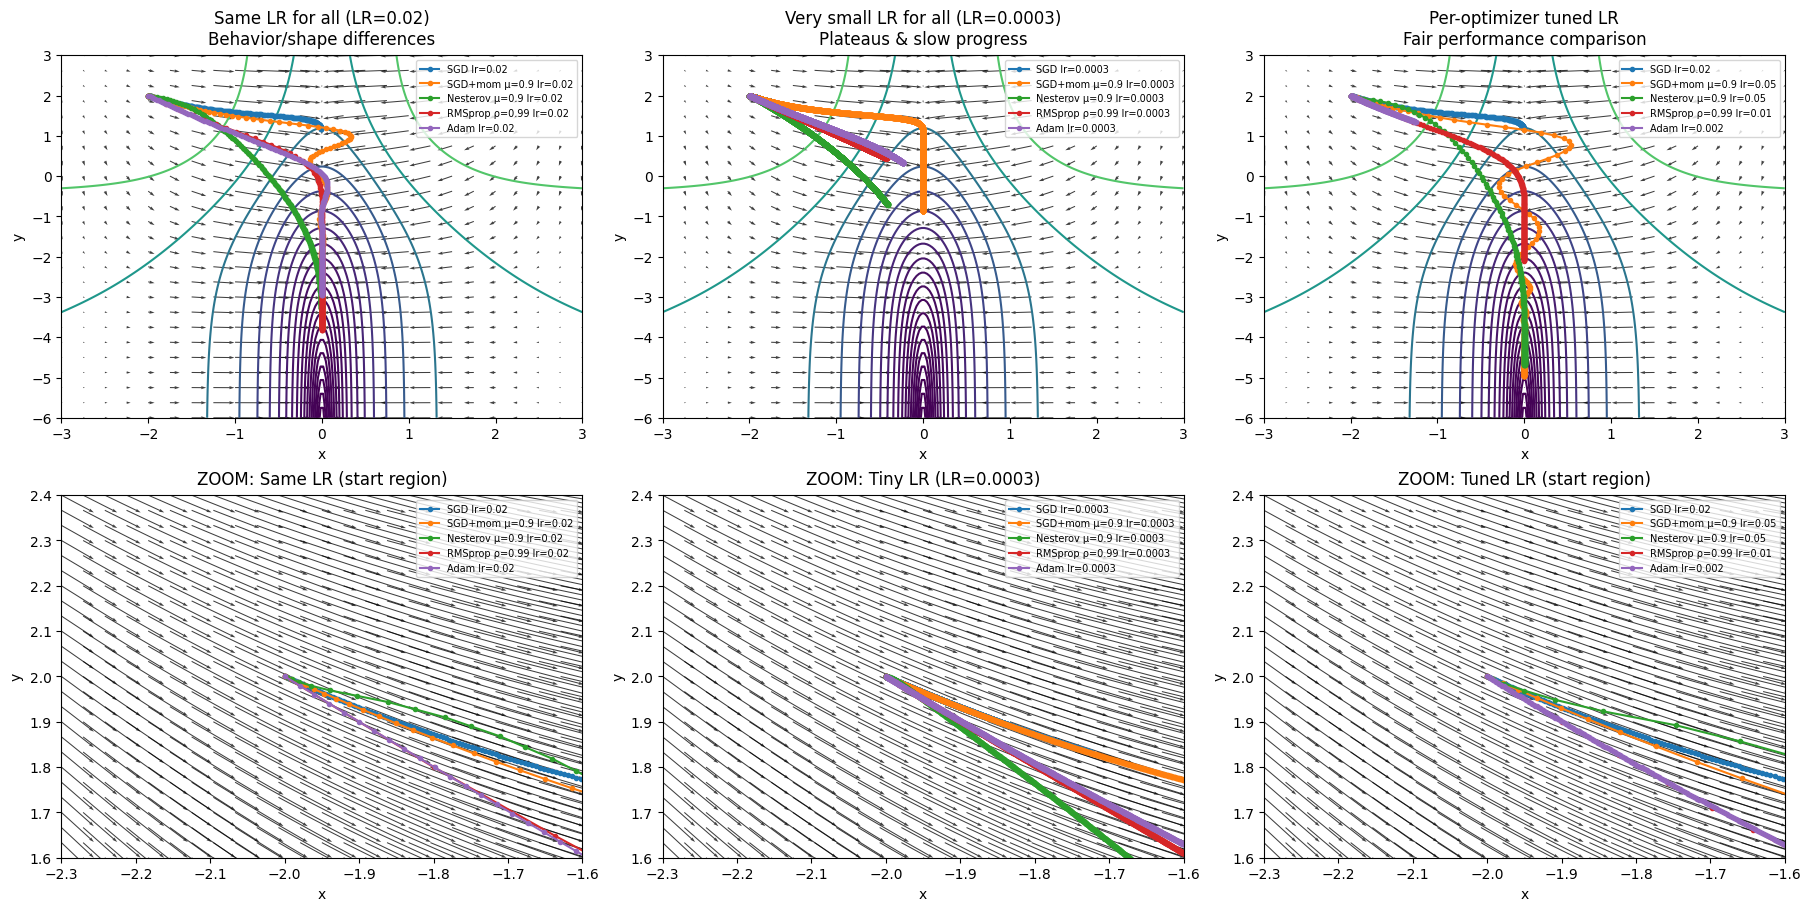

In [ ]:

def plot_contours_with_field_ax(ax, paths, title, xlim=(-3,3), ylim=(-6,3)):
    XX,YY,ZZ,xv,yv,U,V = contour_and_field(xlim, ylim)
    ax.contour(XX, YY, ZZ, levels=np.geomspace(1e-3, ZZ.max()+1e-2, 25))
    ax.quiver(xv, yv, U, V, angles='xy', width=0.002, scale_units='xy', scale=1, alpha=0.75)
    for pts, label in (paths or []):
        pts = np.array(pts)
        ax.plot(pts[:,0], pts[:,1], marker='.', lw=1.5, label=label)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title, pad=8)
    if paths: ax.legend(fontsize=7, loc='upper right', frameon=True)

# build paths for the three scenarios
xy0 = [-2.0, 2.0]
steps_std  = 300
steps_tiny = 5000

# A) SAME LR for all (behavior/shape differences)
LR_same = 0.02
paths_A = [
    (run_path(xy0, SGD2D(lr=LR_same), steps=steps_std),               f"SGD lr={LR_same}"),
    (run_path(xy0, SGDM2D(lr=LR_same, mu=0.9), steps=steps_std),      f"SGD+mom μ=0.9 lr={LR_same}"),
    (run_path(xy0, Nesterov2D(lr=LR_same, mu=0.9), steps=steps_std),  f"Nesterov μ=0.9 lr={LR_same}"),
    (run_path(xy0, RMSprop2D(lr=LR_same, rho=0.99), steps=steps_std), f"RMSprop ρ=0.99 lr={LR_same}"),
    (run_path(xy0, Adam2D(lr=LR_same), steps=steps_std),              f"Adam lr={LR_same}"),
]

# B) TINY LR for all (plateaus & slow progress) -- more steps to see motion
LR_tiny = 3e-4
paths_B = [
    (run_path(xy0, SGD2D(lr=LR_tiny), steps=steps_tiny),               f"SGD lr={LR_tiny:g}"),
    (run_path(xy0, SGDM2D(lr=LR_tiny, mu=0.9), steps=steps_tiny),      f"SGD+mom μ=0.9 lr={LR_tiny:g}"),
    (run_path(xy0, Nesterov2D(lr=LR_tiny, mu=0.9), steps=steps_tiny),  f"Nesterov μ=0.9 lr={LR_tiny:g}"),
    (run_path(xy0, RMSprop2D(lr=LR_tiny, rho=0.99), steps=steps_tiny), f"RMSprop ρ=0.99 lr={LR_tiny:g}"),
    (run_path(xy0, Adam2D(lr=LR_tiny), steps=steps_tiny),              f"Adam lr={LR_tiny:g}"),
]

# C) TUNED per optimizer (fair performance comparison)
paths_C = [
    (run_path(xy0, SGD2D(lr=0.02), steps=steps_std),                      "SGD lr=0.02"),
    (run_path(xy0, SGDM2D(lr=0.05, mu=0.9), steps=steps_std),             "SGD+mom μ=0.9 lr=0.05"),
    (run_path(xy0, Nesterov2D(lr=0.05, mu=0.9), steps=steps_std),         "Nesterov μ=0.9 lr=0.05"),
    (run_path(xy0, RMSprop2D(lr=0.01, rho=0.99), steps=steps_std),        "RMSprop ρ=0.99 lr=0.01"),
    (run_path(xy0, Adam2D(lr=0.002), steps=steps_std),                    "Adam lr=0.002"),
]

# ---------- figure: 2 rows x 3 columns ----------
fig, axes = plt.subplots(2, 3, figsize=(18, 9), constrained_layout=True)

# top row: full view
plot_contours_with_field_ax(axes[0,0], paths_A, "Same LR for all (LR=0.02)\nBehavior/shape differences")
plot_contours_with_field_ax(axes[0,1], paths_B, f"Very small LR for all (LR={LR_tiny:g})\nPlateaus & slow progress")
plot_contours_with_field_ax(axes[0,2], paths_C, "Per-optimizer tuned LR\nFair performance comparison")

# bottom row: zoomed starts (makes tiny motions visible)
zoom_x = (-2.3, -1.6); zoom_y = (1.6, 2.4)  # around the start at (-2, 2)
plot_contours_with_field_ax(axes[1,0], paths_A, "ZOOM: Same LR (start region)", xlim=zoom_x, ylim=zoom_y)
plot_contours_with_field_ax(axes[1,1], paths_B, f"ZOOM: Tiny LR (LR={LR_tiny:g})", xlim=zoom_x, ylim=zoom_y)
plot_contours_with_field_ax(axes[1,2], paths_C, "ZOOM: Tuned LR (start region)", xlim=zoom_x, ylim=zoom_y)

plt.show()


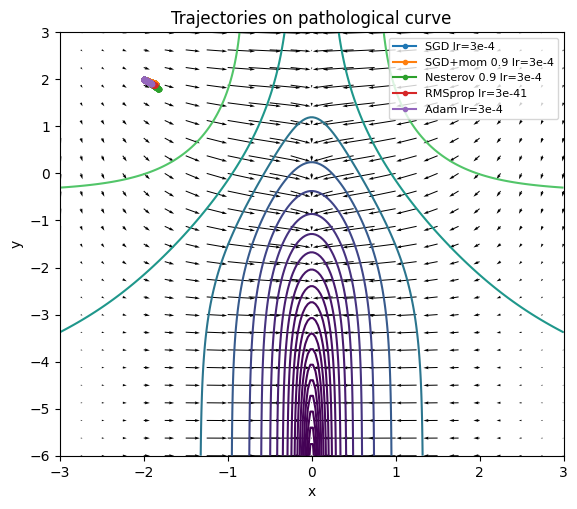

In [ ]:
xy0 = [-2.0, 2.0]
paths = []
paths.append((run_path(xy0, SGD2D(lr=3e-3), steps=300), "SGD lr=3e-4"))
paths.append((run_path(xy0, SGDM2D(lr=3e-4, mu=0.9), steps=300), "SGD+mom 0.9 lr=3e-4"))
paths.append((run_path(xy0, Nesterov2D(lr=3e-4, mu=0.9), steps=300), "Nesterov 0.9 lr=3e-4"))
paths.append((run_path(xy0, RMSprop2D(lr=3e-4, rho=0.99), steps=300), "RMSprop lr=3e-41"))
paths.append((run_path(xy0, Adam2D(lr=3e-4), steps=300), "Adam lr=3e-4"))

plot_contours_with_field(paths, title="Trajectories on pathological curve")


Note:

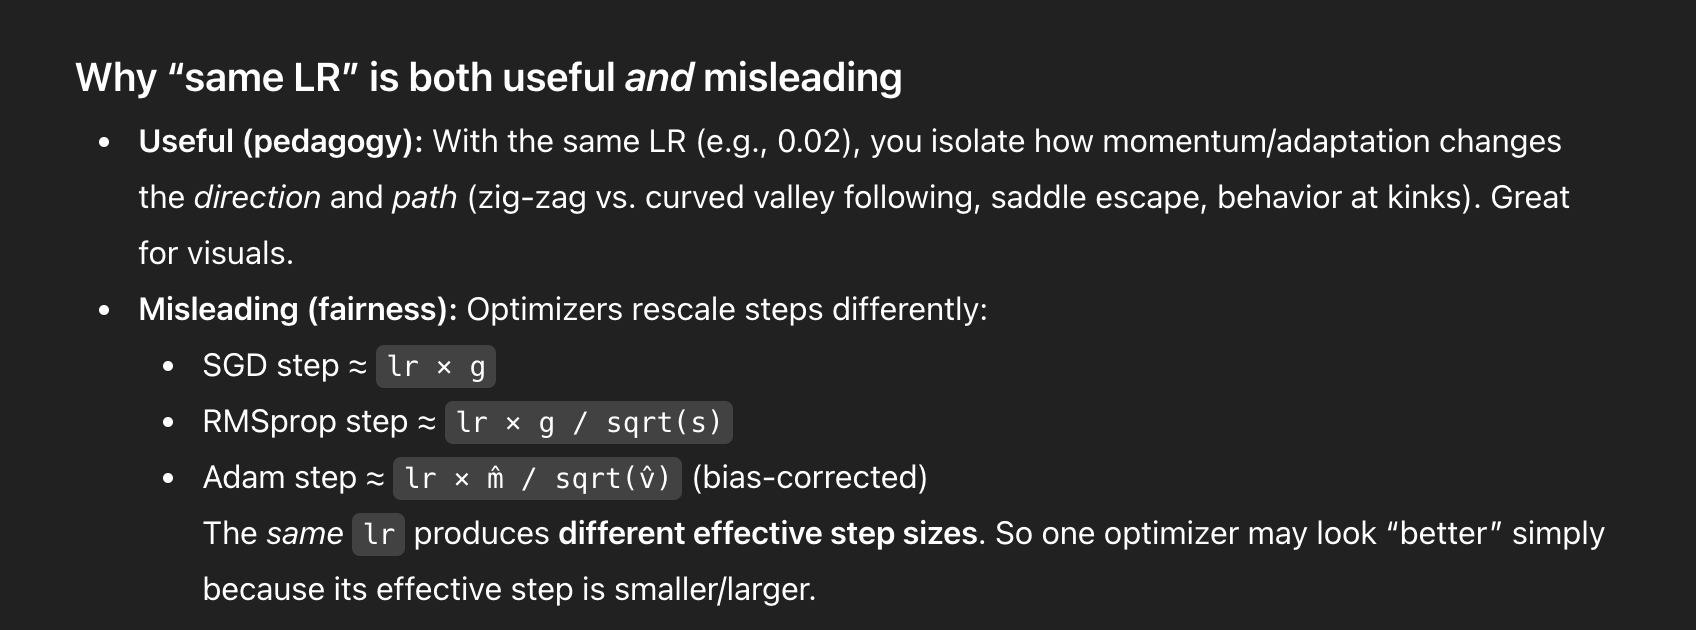

Insights:
- Panel A: With the same LR, optimizers produce different effective step sizes/directions. Great for seeing qualitative behavior, not for judging “which is best.” - SGD jitters; momentum spirals; Nesterov corrects earlier; adaptives follow the valley.
- Panel B: Very small learning rate for all (LR = 3e-4): plateaus & slow progress - On tanh plateaus + sigmoid tail, gradients are tiny; adaptive methods further downscale by √(EMA of grad²), so the effective step becomes minuscule - demonstrates vanishing-gradient regions and why schedules/warmup matter - Same tiny LR ≠ fair comparison either; it hides behavior and makes adaptives look “stuck” simply because they shrink steps by design.
-Panel C:

In terms of optimization, you can image that `x` and `y` are weight parameters, and the curvature represents the loss surface over the space of `x` and `y`. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of `y`. However, if we encounter a point along the ridges, the gradient is much greater in `x` than `y`, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface.

### Exercise - implement `opt_fn_with_sgd`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

Implement the `opt_fn_with_sgd` function using `torch.optim.SGD`. This function optimizes parameters `(x, y)` (which represent coordinates at which we evaluate a function) using gradient descent on that function value. In other words, this should look just like your optimization loops in previous days' material, except rather than passing in `model.parameters()` to your optimizer, you pass in `(xy,)` (because it needs to be an iterable of parameters, not just a single parameter).

Remember, your update steps `optimizer.step()` will automatically change the values of `xy` inplace - this means that you shouldn't store past values like `xy_list.append(xy)` because then past elements of that list will be modified when `xy` is updated. Instead, you should use something like `xy_list.append(xy.detach().clone())` to make sure you're returning a copy of the tensor, which won't continue to be modified.

We've also provided you with a function `plot_fn_with_points`, which plots a function as well as a list of points produced by functions like the one above. The code below starts from `(2.5, 2.5)` and adds the resulting trajectory of `(x, y)` coordinates to the contour plot. Does it find the minimum? Play with the learning rate and momentum a bit and see how close you can get within 100 iterations.

In [ ]:
import torch as t
from torch import optim
from typing import Callable

def opt_fn_with_sgd(
    fn: Callable,
    xy: t.Tensor,
    lr: float = 0.001,
    momentum: float = 0.98,
    n_iters: int = 100
) -> t.Tensor:
    """
    Optimize a scalar-valued function of (x, y) starting from `xy` using SGD.

    Args:
        fn: callable taking (x, y) tensors and returning a scalar loss
        xy: tensor of shape (2,) with requires_grad=True
        lr: learning rate for SGD
        momentum: momentum for SGD
        n_iters: number of update steps

    Returns:
        Tensor of shape (n_iters+1, 2) containing the trajectory, including the start.
    """
    assert xy.shape == (2,)
    assert xy.requires_grad, "xy must be a leaf tensor with requires_grad=True"

    # Create optimizer over the single parameter tensor `xy`
    optimizer = optim.SGD([xy], lr=lr, momentum=momentum)

    # Store a copy of the starting point
    traj = [xy.detach().clone()]

    for _ in range(n_iters):
        # 1) zero old gradients
        optimizer.zero_grad()

        # 2) compute loss at current (x, y)
        loss = fn(xy[0], xy[1])

        # 3) backprop to get grad wrt xy
        loss.backward()

        # 4) update xy in-place
        optimizer.step()

        # 5) save a copy of the new point (avoid aliasing!)
        traj.append(xy.detach().clone())

    return t.stack(traj, dim=0)


In [ ]:
points = []
optimizer_list = [
    (optim.SGD, {"lr": 0.1, "momentum": 0.0}),
    (optim.SGD, {"lr": 0.02, "momentum": 0.99}),
    (optim.SGD, {"lr": 3e-4, "momentum": 0.99}),
    (optim.SGD, {"lr": 1.000, "momentum": 0.99}),
    (optim.SGD, {"lr": 0.0, "momentum": 0.99}),
    (optim.SGD, {"lr": 0.0, "momentum": 0.99}),

]

for _, params in optimizer_list:
    xy = t.tensor([2.5, 2.5], requires_grad=True)
    xys = opt_fn_with_sgd(pathological_curve_loss, xy=xy, lr=params["lr"], momentum=params["momentum"])
    points.append((xys, optim.SGD, params))
    print(f"{params=}, last point={xys[-1]}")

plot_fn_with_points(pathological_curve_loss, points=points, min_points=[(0, "y_min")])


params={'lr': 0.1, 'momentum': 0.0}, last point=tensor([0.2300, 1.4820])
params={'lr': 0.02, 'momentum': 0.99}, last point=tensor([ 0.7196, -6.4586])
params={'lr': 0.0003, 'momentum': 0.99}, last point=tensor([2.4285, 2.4206])
params={'lr': 1.0, 'momentum': 0.99}, last point=tensor([ -0.9849, -81.9371])
params={'lr': 0.0, 'momentum': 0.99}, last point=tensor([2.5000, 2.5000])
params={'lr': 0.0, 'momentum': 0.99}, last point=tensor([2.5000, 2.5000])


| Setting (legend)                          | What you see                                       | Why it happens                                                                                    | Takeaway                                                            |
| ----------------------------------------- | -------------------------------------------------- | ------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **SGD: lr=0.1, momentum=0.0** (red)       | Curved but **zig-zaggy** path; slows near the kink | No momentum → steps follow raw gradient; anisotropic curvature → oscillations                     | Plain SGD needs **schedules** or **momentum** to make good progress |
| **SGD: lr=0.02, momentum=0.99** (blue)    | **Smooth** approach that bends into the valley     | Momentum averages recent gradients → damps cross-valley bounces                                   | A **moderate LR + momentum** tracks the valley well                 |
| **SGD: lr=0.0003, momentum=0.99** (green) | **Barely moves** in 100 steps                      | Tiny LR + vanishing grads (tanh plateaus, sigmoid tail) → tiny effective step                     | Either **raise LR**, **run more steps**, or **zoom** to see motion  |
| **SGD: lr=1.0, momentum=0.99** (purple)   | Huge **loopy arc**, shoots far down the valley     | Effective speed with momentum ≈ lr / (1−μ); with μ=0.99, lr=1.0 ⇒ ~**100×** speed → **overshoot** | High LR + high momentum is **unstable** in sharp/curved regions     |
| **SGD: lr=0.0, momentum=0.99** (orange)   | Stays at start                                     | No learning signal                                                                                | Sanity check: LR must be **> 0**                                    |


## Build Your Own Optimizers

Now let's build our own drop-in replacement for these three classes from `torch.optim`. For each of the exercises you'll have to translate pseudocode that we give you into actual code. If you want an extra challenge, you can try and work directly from the pseudocode in the PyTorch documentation page rather than what we give you.

> **A warning regarding in-place operations**
>
> Be careful with expressions like `x = x + y` and `x += y`. They are NOT equivalent in Python.
>
> - The first one allocates a new `Tensor` of the appropriate size and adds `x` and `y` to it, then rebinds `x` to point to the new variable. The original `x` is not modified.
> - The second one modifies the storage referred to by `x` to contain the sum of `x` and `y` - it is an "in-place" operation. `x.add_(y)` and `torch.add(x, y, out=x)` also work the same way.
>
> Another example: if `x` and `y` are the same shape, then `x = y` won't change the value of `x` inplace, but `x.copy_(y)` will (i.e. changing its values to the values of `y`).
>
> When you're updating parameters in your network you _should_ use inplace operations (because your `optimizer` was passed an iterable of parameters, and so defining a new parameter value via `theta = theta - step` will take it out of the optimizer's scope - it will continue to point to the old, unmodified version).
>
> However, be careful of using inplace operations where you shouldn't be - you don't want to accidentally do something like modify the gradients manually!

### Exercise - implement SGD

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 25-35 minutes on this exercise.
> This is the first of several exercises like it. The first will probably take the longest.
> ```

First, you should implement stochastic gradient descent. It should be like the [PyTorch version](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), but assume `nesterov=False`, `maximize=False`, and `dampening=0`. The pseudocode simplifies to:

$
b_0 \leftarrow 0 \\
\text {for } t=1 \text { to } \ldots \text { do } \\
\quad\; g_t \leftarrow \nabla_\theta f_t\left(\theta_{t-1}\right) \\
\quad\; \text {if } \lambda \neq 0 \\
\quad\;\quad\; g_t \leftarrow g_t+\lambda \theta_{t-1} \\
\quad\; \text {if } \mu \neq 0 \\
\quad\;\quad\; b_t \leftarrow \mu b_{t-1} + g_t \\
\quad\;\quad\; g_t \leftarrow b_t \\
\quad\; \theta_t \leftarrow \theta_{t-1} - \gamma g_t
$

where $\theta_t$ are the parameters, $g_t$ are the gradients (after being modified by operations like weight decay & momentum if necessary), and $b_t$ are the values we track to implement momentum.

<details>
<summary>Derivation of the simplified pseudocode</summary>

We start by removing the "if nesterov" and "if maximize" sections, since we're not using either of those. We also substitute $\tau=0$ since we're not using dampening. This gives us:

$
\text {for } t=1 \text { to } \ldots \text { do } \\
\quad\; g_t \leftarrow \nabla_\theta f_t\left(\theta_{t-1}\right) \\
\quad\; \text {if } \lambda \neq 0 \\
\quad\;\quad\; g_t \leftarrow g_t+\lambda \theta_{t-1} \\
\quad\; \text {if } \mu \neq 0 \\
\quad\;\quad\; \text{if } t>1 \\
\quad\;\quad\;\quad\; b_t \leftarrow \mu b_{t-1} + g_t \\
\quad\;\quad\; else \\
\quad\;\quad\;\quad\; b_t \leftarrow g_t \\
\quad\;\quad\; g_t \leftarrow b_t \\
\quad\; \theta_t \leftarrow \theta_{t-1} - \gamma g_t
$

Finally, we observe that we can set $b_0 = 0$ and then remove the special case handling of the $t=1$ case, which gives us the pseudocode above.

</details>

You should complete the `step` method below, which implements the algorithm described by the pseudocode above. Note that we've added the `torch.inference_mode` decorator to the `step` method, which is equivalent to using the context manager `with torch.inference_mode():`. This is similar to `torch.no_grad`; the difference between them isn't worth getting into here but in general know that `torch.inference_mode` is mostly preferred.

The configurations used during `tests.test_sgd` will start simple (e.g. all parameters set to zero except `lr`) and gradually move to more complicated ones. This will help you track exactly where in your model the error is coming from.


You should also read the `__init__` and `zero_grad` methods, making sure you understand how these work and what they are doing. Note that setting `grad=None` like the code below is treated as equivalent to setting `grad` equal to a tensor of zeros, i.e. the first time we're required to do an operation on the gradient it'll be replaced with this. Making it be `None` by default is the standard, so as to not use unnecessary memory.

In [ ]:
class SGD:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float,
        momentum: float = 0.0,
        weight_decay: float = 0.0,
    ):
        """Implements SGD with momentum (no Nesterov, no dampening, no maximize)."""
        self.params = list(params)
        self.lr = lr
        self.mu = momentum
        self.lmda = weight_decay
        # momentum buffers, one per param
        self.b = [t.zeros_like(p) for p in self.params]

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        """One SGD step: (optionally) add L2 to grad, update momentum buffer, then update params."""
        for i, p in enumerate(self.params):
            g = p.grad
            if g is None:
                continue

            # L2-coupled weight decay (same as PyTorch's SGD weight_decay)
            if self.lmda != 0.0:
                g = g + self.lmda * p

            # Momentum (no dampening)
            if self.mu != 0.0:
                self.b[i].mul_(self.mu).add_(g)   # b = mu*b + g
                d_p = self.b[i]
            else:
                d_p = g

            # Parameter update (minimization)
            p.add_(d_p, alpha=-self.lr)

    def __repr__(self) -> str:
        return f"SGD(lr={self.lr}, momentum={self.mu}, weight_decay={self.lmda})"

    tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'weight_decay': 0.0}
Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'weight_decay': 0.0}
Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.0}
Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.05}
Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'weight_decay': 0.05}
All tests in `test_sgd` passed!



```
CLASS SGD
  INPUTS:
    params        # iterable of parameters θ₁, θ₂, ...
    lr            # learning rate (scalar)
    momentum = 0  # μ ∈ [0,1)
    weight_decay = 0  # λ ≥ 0 (L2-coupled)

  INIT:
    self.params ← list(params)
    self.lr     ← lr
    self.mu     ← momentum
    self.lmda   ← weight_decay
    # momentum buffers, one per parameter (same shape as param)
    self.buffers ← [ zeros_like(p) FOR p IN self.params ]

  METHOD zero_grad():
    FOR p IN self.params:
      p.grad ← None

  METHOD step():   # one optimization update
    FOR i, p IN enumerate(self.params):

      g ← p.grad
      IF g IS None:
        CONTINUE   # skip parameters with no gradient

      # ---- (1) L2-coupled weight decay ----
      # Equivalent to adding λ * ||θ||² / 2 to the loss:
      # g ← g + λ * θ
      IF self.lmda ≠ 0:
        g ← g + self.lmda * p

      # ---- (2) Momentum (no dampening, no Nesterov) ----
      # buffer b_i stores running sum of gradients:
      # b_i ← μ * b_i + g
      IF self.mu ≠ 0:
        self.buffers[i] ← self.mu * self.buffers[i] + g
        d_p ← self.buffers[i]
      ELSE:
        d_p ← g

      # ---- (3) Parameter update (minimize) ----
      # θ ← θ - lr * d_p
      p ← p - self.lr * d_p

  METHOD __repr__():
    RETURN "SGD(lr={lr}, momentum={μ}, weight_decay={λ})"
```



If you feel comfortable with this implementation, you can skim through the remaining ones, since there's diminishing marginal returns to be gained from doing the actual exercises. We still recommend you read the content on the optimizers before the actual exercises, because they contain useful theory to understand. If you want an extra challenge in the actual exercises, you can try and implement the optimization algorithms directly from the PyTorch documentation pseudocode rather than from the simplified pseudocode we give you.

### RMSProp (and adaptive methods)

From SGD, we'll move onto discussing **adaptive gradient descent methods**. These are methods which automatically adjust the learning rate of each parameter during training, based on the size of gradients at previous steps. In a sense this is similar to how momentum operates in SGD, but we don't tend to describe SGD plus momentum as an adaptive method. When discussing momentum, we usually think of the analogy of a ball rolling down a hill, and the ball's velocity accelerates until it reaches some terminal velocity. The momentum parameter $\mu$ controls the terminal velocity: as $\mu \to 1$ the terminal velocity gets very high, which also means it can take a long time to adjust its speed when it enters new territory. In contrast, adaptive methods are better thought of as deliberate, conscious updates to the learning rate of parameters based on past values. They allow us to speed up when we need to, but without sacrificing our ability to adapt quickly when we enter new regimes.

The first adaptive method we'll look at is **RMSprop**. This is actually the second main adaptive method that was proposed in the optimization literature, after AdaGrad (however the problem with AdaGrad is that it decays the learning rates too quickly - this is the problem that RMSprop solves). RMSprop is similar to SGD, with an added dynamic: **the size of parameter steps are scaled according to the variance of past gradients**, with higher variance leading to smaller steps. Intuitively, if you're in a very monotonic region of the loss landscape then you want to take larger steps (since you know where you're going and you just want to get there quickly), whereas if you're in a very noisy region and possibly oscillating around minima then you want to take smaller steps.

One final note - when we're using non-adaptive methods like SGD we tend to have an inverse relationship between the learning rate and the batch size. Broadly speaking, this is because a larger batch size means our gradients will have smaller variance, and so we can safely use a larger learning rate. This generally isn't necessary for adaptive methods since the learning rates will be adjusted automatically during training based on the variance of our gradients - we don't need to manually scale them ourselves. Most commonly during optimization, we'll start with the default hyperparameters for whatever adaptive optimizer we're using, and then adjust from there.

### Exercise - implement RMSprop

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 15-25 minutes on this exercise.
> ```

Below, you should implement RMSprop in the same way as you implemented SGD. The pseudocode is slightly more complicated, since we now have to track 2 variables: $b_t$ for applying the momentum effect, and $v_t$ for tracking the variance of past gradients (we've called these `b` and `v` below).

[Here](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) is a link to the PyTorch version, alternatively you can use our simplified pseudocode again:

<details>
<summary>Click here for the simplified pseudocode</summary>

$
b_0 \leftarrow 0 \\
\text {for } t=1 \text { to } \ldots \text { do } \\
\quad\; g_t \leftarrow \nabla_\theta f_t\left(\theta_{t-1}\right) \\
\quad\; \text {if } \lambda \neq 0 \\
\quad\;\quad\; g_t \leftarrow g_t+\lambda \theta_{t-1} \\
\quad\; v_t \leftarrow \alpha v_{t-1} + (1-\alpha) g_t^2 \\
\quad\; g_t \leftarrow g_t / (\sqrt{v_t} + \epsilon) \\
\quad\; \text {if } \mu \neq 0 \\
\quad\;\quad\; b_t \leftarrow \mu b_{t-1} + g_t \\
\quad\;\quad\; g_t \leftarrow b_t \\
\quad\; \theta_t \leftarrow \theta_{t-1} - \gamma g_t
$

Note that we've reordered the pseudocode slightly differently to the PyTorch docs, so that we divide $g_t$ by $\sqrt{v_t + \epsilon}$ before applying momentum. Both ways are equivalent though.

</details>

In [ ]:
class RMSprop:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float = 0.01,
        alpha: float = 0.99,
        eps: float = 1e-08,
        weight_decay: float = 0.0,
        momentum: float = 0.0,
    ):
        """Implements RMSprop (uncentered)."""
        self.params = list(params)  # in case a generator was passed
        self.lr = lr
        self.eps = eps
        self.mu = momentum
        self.lmda = weight_decay
        self.alpha = alpha

        # momentum buffer and EMA of squared grads (same shapes as params)
        self.b = [t.zeros_like(p) for p in self.params]  # momentum buffer
        self.v = [t.zeros_like(p) for p in self.params]  # EMA of g^2

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        """One RMSprop step: update v (EMA of g^2), optionally apply momentum, then update params."""
        a = self.alpha
        for i, p in enumerate(self.params):
            g = p.grad
            if g is None:
                continue

            # L2-coupled weight decay (same semantics as torch.optim.RMSprop(weight_decay=...))
            if self.lmda != 0.0:
                g = g + self.lmda * p

            # Exponential moving average of squared gradients
            # v = alpha * v + (1 - alpha) * g^2
            v_i = self.v[i]
            v_i.mul_(a).addcmul_(g, g, value=(1.0 - a))

            # Denominator for scaling (uncentered RMSprop)
            denom = v_i.sqrt().add_(self.eps)

            if self.mu != 0.0:
                # momentum buffer: b = mu * b + g / denom
                b_i = self.b[i]
                b_i.mul_(self.mu).addcdiv_(g, denom)
                d_p = b_i
            else:
                d_p = g / denom

            # Parameter update (minimization)
            p.add_(d_p, alpha=-self.lr)

    def __repr__(self) -> str:
        return (
            f"RMSprop(lr={self.lr}, eps={self.eps}, momentum={self.mu}, "
            f"weight_decay={self.lmda}, alpha={self.alpha})"
        )

tests.test_rmsprop(RMSprop)

Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
All tests in `test_rmsprop` passed!




```
CLASS RMSprop
  INPUTS:
    params            # iterable of parameters θ₁, θ₂, ...
    lr                # learning rate (scalar)
    alpha = 0.99      # EMA decay for squared gradients (ρ)
    eps   = 1e-8      # numerical stability term
    weight_decay = 0  # λ ≥ 0 (L2-coupled)
    momentum    = 0   # μ ∈ [0,1)

  INIT:
    self.params ← list(params)
    self.lr     ← lr
    self.alpha  ← alpha
    self.eps    ← eps
    self.lmda   ← weight_decay
    self.mu     ← momentum
    # Per-parameter state:
    self.v ← [ zeros_like(p) FOR p IN self.params ]   # EMA of g^2
    self.b ← [ zeros_like(p) FOR p IN self.params ]   # momentum buffer (on scaled grad)

  METHOD zero_grad():
    FOR p IN self.params:
      p.grad ← None

  METHOD step():   # one optimization update
    FOR i, p IN enumerate(self.params):
      g ← p.grad
      IF g IS None:
        CONTINUE

      # ---- (1) L2-coupled weight decay on the gradient ----
      # Equivalent to adding (λ/2) * ||θ||^2 to the loss:
      # g_eff = g + λ * θ
      IF self.lmda ≠ 0:
        g ← g + self.lmda * p

      # ---- (2) Update EMA of squared gradients (uncentered) ----
      # v_i = α * v_i + (1 - α) * (g)^2
      self.v[i] ← self.alpha * self.v[i] + (1 - self.alpha) * (g ⊙ g)

      # ---- (3) Build denominator for scaling ----
      # denom = sqrt(v_i) + eps
      denom ← sqrt(self.v[i]) + self.eps

      # ---- (4) Optionally apply momentum on the *scaled* gradient ----
      IF self.mu ≠ 0:
        # b_i = μ * b_i + g / denom
        self.b[i] ← self.mu * self.b[i] + (g / denom)
        d_p ← self.b[i]
      ELSE:
        d_p ← g / denom

      # ---- (5) Parameter update (minimize) ----
      # θ ← θ - lr * d_p
      p ← p - self.lr * d_p

  METHOD __repr__():
    RETURN "RMSprop(lr={lr}, eps={eps}, momentum={μ}, weight_decay={λ}, alpha={α})"
```

### Mini cheatsheet

* **EMA of squared grads:** `v ← α·v + (1−α)·g²`
* **Scale factor:** `denom = sqrt(v) + eps`
* **Momentum buffer (if used):** `b ← μ·b + (g / denom)`
* **Update:** `θ ← θ − lr · (b  or  g/denom)`
* **Weight decay (L2-coupled):** `g ← g + λ·θ` (same semantics as PyTorch’s `weight_decay`).


### Adam, and "momentum"

We'll end by implementing Adam and AdamW, two of the most popular optimizers in deep learning. These combine the benefits of RMSprop and SGD with momentum: they have the same variance-based scaling as RMSprop, but they also have an update rule based on the first moment of gradients as well.

There's an important clarification to make here - the first order adjustment of Adam is sometimes called momentum as a shorthand, but there's an important sense in which it isn't. The key difference is that SGD's momentum causes acceleration until we hit terminal velocity, which could be very large for $\mu \approx 1$. In contrast, Adam's momentum is an exponentially weighted moving average - the parameter $\beta_1$ controls how quickly it adjusts (with a value closer to 1 meaning it adjust to newer values more slowly), but it doesn't change the terminal velocity in any sense. Mathematically, the difference between these two is minimal (all you'd need to do is take Adam's update rule $m_t \leftarrow \beta_1 m_{t-1} + (1-\beta_1) g_t$ and change it to $m_t \leftarrow \beta_1 m_{t-1} + g_t$ for it to have the same qualitative behaviour as SGD), but this extra factor makes a lot of difference!

### Exercise - implement Adam

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

This should just be an extension of your RMSprop implementation. You still have 2 variables to track, but now the variable $b_t$ for applying momentum has been replaced with $m_t$ for tracking the exponentially weighted moving average of first order moments.

[Here's](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) a link to the PyTorch version, alternatively you can use the simplified pseudocode below:

<details>
<summary>Click here for the simplified pseudocode</summary>

$
\text {for } t=1 \text { to } \ldots \text { do } \\
\quad\; g_t \leftarrow \nabla_\theta f_t\left(\theta_{t-1}\right) \\
\quad\; \text {if } \lambda \neq 0 \\
\quad\;\quad\; g_t \leftarrow g_t+\lambda \theta_{t-1} \\
\quad\; m_t \leftarrow \beta_1 m_{t-1} + (1-\beta_1) g_t \\
\quad\; v_t \leftarrow \beta_2 v_{t-1} + (1-\beta_2) g_t^2 \\
\quad\; \widehat{m_t} \leftarrow m_t / (1 - \beta_1^t) \\
\quad\; \widehat{v_t} \leftarrow v_t / (1 - \beta_2^t) \\
\quad\; \theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t} / (\sqrt{\widehat{v_t}} + \epsilon)
$

</details>

Note - we center our first & second moment estimators by dividing by $1 - \beta^t$, which means for this optimizer we do have to track the variable $t$ (make sure to remember to increment it after each use of the `step` function). We do this because Adam's exponentially weighted moving average would otherwise take a while to converge to the true mean (since its estimates initially behave like the truncated sum of a geometric series). We leave it as an exercise for the reader to derive this (hint - try assuming the expected value $\mathbb{E}[g_t] = g_0$ is the same for all $t$, what does the expression $\mathbb{E}[m_t]$ simplify to?).

In [ ]:
class Adam:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float = 0.001,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-08,
        weight_decay: float = 0.0,
    ):
        """Implements Adam (amsgrad=False, maximize=False)."""
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.lmda = weight_decay
        self.t = 1  # step counter used for bias correction (first update uses t=1)

        # first- and second-moment buffers
        self.m = [t.zeros_like(p) for p in self.params]
        self.v = [t.zeros_like(p) for p in self.params]

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        """One Adam step: L2-coupled decay -> moments -> bias-correct -> param update."""
        b1, b2 = self.beta1, self.beta2
        b1_c = 1.0 - (b1 ** self.t)   # bias-correction denominators
        b2_c = 1.0 - (b2 ** self.t)

        for i, p in enumerate(self.params):
            g = p.grad
            if g is None:
                continue

            # L2-coupled weight decay (same semantics as torch.optim.Adam(weight_decay=...))
            if self.lmda != 0.0:
                g = g + self.lmda * p

            # Update moments
            # m = b1*m + (1-b1)*g
            # v = b2*v + (1-b2)*g^2
            self.m[i].mul_(b1).add_(g, alpha=1.0 - b1)
            self.v[i].mul_(b2).addcmul_(g, g, value=1.0 - b2)

            # Bias correction
            m_hat = self.m[i] / b1_c
            v_hat = self.v[i] / b2_c

            # Parameter update: p -= lr * m_hat / (sqrt(v_hat) + eps)
            p.addcdiv_(m_hat, v_hat.sqrt().add_(self.eps), value=-self.lr)

        # advance step counter
        self.t += 1

    def __repr__(self) -> str:
        return (
            f"Adam(lr={self.lr}, beta1={self.beta1}, beta2={self.beta2}, eps={self.eps}, "
            f"weight_decay={self.lmda})"
        )

tests.test_adam(Adam)

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
All tests in `test_adam` passed!




```
CLASS Adam
  INPUTS:
    params                 # iterable of parameters θ₁, θ₂, …
    lr                     # learning rate
    betas = (β1, β2)       # (first-, second-moment decays), e.g., (0.9, 0.999)
    eps                    # small constant for numerical stability
    weight_decay = λ       # L2-coupled weight decay (add λ·θ to gradient)

  INIT:
    self.params ← list(params)
    self.lr     ← lr
    self.beta1  ← β1
    self.beta2  ← β2
    self.eps    ← eps
    self.lmda   ← λ
    self.t      ← 1                 # time step (for bias correction)
    # Per-parameter state (same shape as θᵢ):
    self.m ← [ zeros_like(p) FOR p IN self.params ]   # first moment (EMA of gradients)
    self.v ← [ zeros_like(p) FOR p IN self.params ]   # second moment (EMA of squared grads)

  METHOD zero_grad():
    FOR p IN self.params:
      p.grad ← None

  METHOD step():   # one optimization update
    b1 ← self.beta1
    b2 ← self.beta2
    # precompute bias-correction denominators for time step t
    bc1 ← 1 - (b1 ^ self.t)         # for m̂
    bc2 ← 1 - (b2 ^ self.t)         # for v̂

    FOR i, p IN enumerate(self.params):
      g ← p.grad
      IF g IS None:
        CONTINUE

      # (1) L2-coupled weight decay on gradient: g_eff = g + λ·θ
      IF self.lmda ≠ 0:
        g ← g + self.lmda * p

      # (2) Update biased moment estimates
      # m_i ← β1 * m_i + (1 - β1) * g
      # v_i ← β2 * v_i + (1 - β2) * (g ⊙ g)
      self.m[i] ← b1 * self.m[i] + (1 - b1) * g
      self.v[i] ← b2 * self.v[i] + (1 - b2) * (g ⊙ g)

      # (3) Bias correction
      m_hat ← self.m[i] / bc1
      v_hat ← self.v[i] / bc2

      # (4) Parameter update (minimize):
      # θ ← θ - lr * m̂ / (sqrt(v̂) + eps)
      p ← p - self.lr * ( m_hat / ( sqrt(v_hat) + self.eps ) )

    # (5) Advance time step
    self.t ← self.t + 1

  METHOD __repr__():
    RETURN "Adam(lr={lr}, beta1={β1}, beta2={β2}, eps={eps}, weight_decay={λ})"
```

### Mini cheatsheet (optional to show under the pseudocode)

* **Moments:** `m ← β1·m + (1−β1)·g`,  `v ← β2·v + (1−β2)·g²`
* **Bias-corrected:** `m̂ = m / (1−β1ᵗ)`, `v̂ = v / (1−β2ᵗ)`
* **Update:** `θ ← θ − lr · m̂ / (√v̂ + eps)`
* **Weight decay (L2-coupled):** use `g ← g + λ·θ` (PyTorch Adam semantics).
  *(For AdamW/decoupled decay, remove `g += λ·θ` and instead do `θ ← θ − lr·λ·θ` as a separate shrink step.)*


### Exercise - implement AdamW

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Finally, you'll adapt your Adam implementation to implement AdamW. This is a very small modification of the Adam update rule, where we apply weight decay in a different way (by modifying the weights $theta_t$ themselves, rather than modifying the gradients $g_t$ and then using those modified gradients in the first & second moment calculations). This means that, unlike with Adam, using weight decay is equivalent to having a Gaussian prior on the weights with mean zero (or alternatively, equivalent to L2 regularization). This is seen as the more "correct" way to implement weight decay, and so AdamW is now generally preferred over Adam.

You can read more about this variant of Adam [here](https://arxiv.org/abs/1711.05101). The PyTorch docs are [here](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html), and the pseudocode is again provided for you below (but for this exercise we do recommend trying to go without it - having to work with more complex pseudocode and parse out the bits that actually matter is a useful exercise!).

<details>
<summary>Click here for the simplified pseudocode</summary>

$
\text {for } t=1 \text { to } \ldots \text { do } \\
\quad\; g_t \leftarrow \nabla_\theta f_t\left(\theta_{t-1}\right) \\
\quad\; \theta_t \leftarrow \theta_{t-1} - \gamma \lambda \theta_{t-1} \\
\quad\; m_t \leftarrow \beta_1 m_{t-1} + (1-\beta_1) g_t \\
\quad\; v_t \leftarrow \beta_2 v_{t-1} + (1-\beta_2) g_t^2 \\
\quad\; \widehat{m_t} \leftarrow m_t / (1 - \beta_1^t) \\
\quad\; \widehat{v_t} \leftarrow v_t / (1 - \beta_2^t) \\
\quad\; \theta_t \leftarrow \theta_t - \gamma \widehat{m_t} / (\sqrt{\widehat{v_t}} + \epsilon)
$

</details>

In [ ]:
import torch as t
from typing import Iterable

class AdamW:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float = 0.001,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-08,
        weight_decay: float = 0.0,
    ):
        """Implements AdamW (decoupled weight decay), amsgrad=False, maximize=False."""
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.lmda = weight_decay
        self.t = 1  # step counter for bias correction

        # per-parameter state
        self.m = [t.zeros_like(p) for p in self.params]  # first moment
        self.v = [t.zeros_like(p) for p in self.params]  # second moment

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        """One AdamW step: decoupled weight decay -> update moments -> bias-correct -> update params."""
        b1, b2 = self.beta1, self.beta2
        bc1 = 1.0 - (b1 ** self.t)   # bias-correction denominators
        bc2 = 1.0 - (b2 ** self.t)

        for i, p in enumerate(self.params):
            g = p.grad
            if g is None:
                continue

            # (1) Decoupled weight decay: p ← p - lr * λ * p
            if self.lmda != 0.0:
                p.add_(p, alpha=-self.lr * self.lmda)

            # (2) Adam moments on raw gradient (no L2 coupling)
            self.m[i].mul_(b1).add_(g, alpha=1.0 - b1)                 # m = β1 m + (1-β1) g
            self.v[i].mul_(b2).addcmul_(g, g, value=1.0 - b2)          # v = β2 v + (1-β2) g^2

            # (3) Bias correction
            m_hat = self.m[i] / bc1
            v_hat = self.v[i] / bc2

            # (4) Parameter update
            p.addcdiv_(m_hat, v_hat.sqrt().add_(self.eps), value=-self.lr)

        self.t += 1

    def __repr__(self) -> str:
        return (
            f"AdamW(lr={self.lr}, beta1={self.beta1}, beta2={self.beta2}, "
            f"eps={self.eps}, weight_decay={self.lmda})"
        )


tests.test_adamw(AdamW)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
All tests in `test_adamw` passed!




```
CLASS AdamW
  INPUTS:
    params                 # iterable of parameters θ₁, θ₂, …
    lr                     # learning rate
    betas = (β1, β2)       # moments' decay factors, e.g. (0.9, 0.999)
    eps                    # small constant for numerical stability
    weight_decay = λ       # decoupled weight decay coefficient

  INIT:
    self.params ← list(params)
    self.lr     ← lr
    self.beta1  ← β1
    self.beta2  ← β2
    self.eps    ← eps
    self.lmda   ← λ
    self.t      ← 1                   # time step (for bias correction)
    # Per-parameter state (same shapes as θᵢ):
    self.m ← [ zeros_like(p) FOR p IN self.params ]   # first moment (EMA of gradients)
    self.v ← [ zeros_like(p) FOR p IN self.params ]   # second moment (EMA of squared grads)

  METHOD zero_grad():
    FOR p IN self.params:
      p.grad ← None

  METHOD step():    # one optimization update
    b1 ← self.beta1
    b2 ← self.beta2
    # Bias-correction denominators for time step t
    bc1 ← 1 − (b1 ^ self.t)
    bc2 ← 1 − (b2 ^ self.t)

    FOR i, p IN enumerate(self.params):
      g ← p.grad
      IF g IS None:
        CONTINUE

      # ---- (1) Decoupled weight decay (AdamW) ----
      # θ ← θ − lr · λ · θ
      IF self.lmda ≠ 0:
        p ← p − self.lr * self.lmda * p

      # ---- (2) Update biased moment estimates on the *pure* gradient ----
      # m_i ← β1 · m_i + (1 − β1) · g
      # v_i ← β2 · v_i + (1 − β2) · (g ⊙ g)
      self.m[i] ← b1 * self.m[i] + (1 − b1) * g
      self.v[i] ← b2 * self.v[i] + (1 − b2) * (g ⊙ g)

      # ---- (3) Bias-correct moments ----
      m_hat ← self.m[i] / bc1
      v_hat ← self.v[i] / bc2

      # ---- (4) Parameter update (minimize) ----
      # θ ← θ − lr · m̂ / ( sqrt(v̂) + eps )
      p ← p − self.lr * ( m_hat / ( sqrt(v_hat) + self.eps ) )

    # ---- (5) Advance time step ----
    self.t ← self.t + 1

  METHOD __repr__():
    RETURN "AdamW(lr={lr}, beta1={β1}, beta2={β2}, eps={eps}, weight_decay={λ})"
```

### Mini cheatsheet

* **Decoupled decay:** `θ ← θ − lr · λ · θ` (separate from gradient)
* **Moments:** `m ← β1 m + (1−β1) g`, `v ← β2 v + (1−β2) g²`
* **Bias-corrected:** `m̂ = m / (1−β1ᵗ)`, `v̂ = v / (1−β2ᵗ)`
* **Update:** `θ ← θ − lr · m̂ / (√v̂ + eps)`


## Plotting multiple optimisers

Finally, we've provided some code which should allow you to plot more than one of your optimisers at once.

### Exercise - experiment with different optimizers & params

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 20-30 minutes on this exercise.
> ```

We've given you a function below which works just like `opt_fn_with_sgd` from earlier, but takes in a general optimizer and hyperparameters (as a dictionary of keyword arguments like `lr` and `momentum`).

You should use this function to play around with different optimizers and hyperparameters, comparing their performance. The code below gives one example of such a comparison, run it now and see what you get:

In [ ]:
def opt_fn(
    fn: Callable,
    xy: Tensor,
    optimizer_class,
    optimizer_hyperparams: dict,
    n_iters: int = 100,
) -> Tensor:
    """Optimize the a given function starting from the specified point.

    optimizer_class: one of the optimizers you've defined, either SGD, RMSprop, or Adam
    optimzer_kwargs: keyword arguments passed to your optimiser (e.g. lr and weight_decay)
    """
    assert xy.requires_grad

    optimizer = optimizer_class([xy], **optimizer_hyperparams)

    xy_list = [
        xy.detach().clone()
    ]  # so that we don't unintentionally modify past values in `xy_list`

    for i in range(n_iters):
        fn(xy[0], xy[1]).backward()
        optimizer.step()
        optimizer.zero_grad()
        xy_list.append(xy.detach().clone())

    return t.stack(xy_list)


points = []

optimizer_list = [
    (SGD, {"lr": 0.03, "momentum": 0.99}),
    (RMSprop, {"lr": 0.02, "alpha": 0.99, "momentum": 0.8}),
    (Adam, {"lr": 0.2, "betas": (0.99, 0.99), "weight_decay": 0.005}),
    (AdamW, {"lr": 0.2, "betas": (0.99, 0.99), "weight_decay": 0.005}),
]

for optimizer_class, params in optimizer_list:
    xy = t.tensor([2.5, 2.5], requires_grad=True)
    xys = opt_fn(
        pathological_curve_loss,
        xy=xy,
        optimizer_class=optimizer_class,
        optimizer_hyperparams=params,
    )
    points.append((xys, optimizer_class, params))

plot_fn_with_points(pathological_curve_loss, min_points=[(0, "y_min")], points=points)

| Setting (legend)                                               | What you see                                                                             | Why it happens                                                                                                                                                    | Key Takeaway                                                                                                        |
| -------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **SGD (red): lr=0.03, momentum=0.99**                          | Moves toward the valley but **spirals / oscillates** before settling                     | Momentum smooths gradients, but curvature around the center is **anisotropic**, so movement overshoots and corrects repeatedly                                    | SGD+momentum is effective but **sensitive to LR** in sharp valleys. Needs tuning or LR schedules.                   |
| **RMSprop (blue): lr=0.02, α=0.99, momentum=0.8**              | Takes **sharper turns** and follows the valley more stably, but progress slows deeper in | RMSprop **rescales step sizes** using running avg of squared gradients → prevents explosion in steep directions but reduces step size when gradients vanish       | RMSprop is **good for pathological curvature**, but can **stall** without LR warmup/decay.                          |
| **Adam (green): lr=0.2, β=(0.99, 0.99), weight_decay=0.005**   | **Fast initial progress** but path curves inward non-smoothly; slight drift              | Adam mixes RMSprop-like scaling + momentum → **large effective step early**, but **L2 in Adam is coupled**, so weight decay interacts with the gradient direction | Adam is fast & adaptive, but **L2 regularization behaves differently** (not pure shrinkage). Tuning β & LR matters. |
| **AdamW (purple): lr=0.2, β=(0.99, 0.99), weight_decay=0.005** | Similar speed to Adam, but **cleaner / more direct path** into the valley                | **Decoupled weight decay (AdamW)** applies shrinkage independently of gradient direction → more stable trajectory                                                 | AdamW fixes Adam’s regularization issue → **use AdamW by default** for modern deep learning.                        |


Note that the focus shouldn't be on figuring out "which one is the best optimizer" - this loss landscape (and other examples we'll give you) were specifically designed to be pathological, and exhibit interesting kinds of behaviours from optimizers. The focus should instead be on understanding how the characteristics of optimizers we discussed in the previous sections are reflected visually in the plots produced on these loss landscapes. Some questions you might want to ask:

- We discussed that Adam (and AdamW) center their first and second moments, so that the early values are large - otherwise they start off small and take a long time to grow. Is this reflected in the plots, i.e. with Adam/AdamW taking larger early steps relative to SGD or RMSprop?
- The momentum used in SGD and RMSprop causes acceleration until "terminal velocity", which is usually a higher cap than Adam and AdamW. Is this reflected in the step size (and the instability) of those optimizers? Do Adam and AdamW seem to adapt slightly faster when they enter new terrain?
- Are there any landscapes where weight decay is advantageous, and can you see why it would be?

Some more functions you might want to try out (with their minima marked on the plots):

In [ ]:
def bivariate_gaussian(x, y, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = 0.5 * ((x - x_mean) ** 2) / (x_sig**2)
    y_exp = 0.5 * ((y - y_mean) ** 2) / (y_sig**2)
    return norm * t.exp(-x_exp - y_exp)


means = [(1.0, -0.5), (-1.0, 0.5), (-0.5, -0.8)]


def neg_trimodal_func(x, y):
    """
    This function has 3 global minima, at `means`. Unstable methods can overshoot these minima, and
    non-adaptive methods can fail to converge to them in the first place given how shallow the
    gradients are everywhere except in the close vicinity of the minima.
    """
    z = -bivariate_gaussian(x, y, x_mean=means[0][0], y_mean=means[0][1], x_sig=0.2, y_sig=0.2)
    z -= bivariate_gaussian(x, y, x_mean=means[1][0], y_mean=means[1][1], x_sig=0.2, y_sig=0.2)
    z -= bivariate_gaussian(x, y, x_mean=means[2][0], y_mean=means[2][1], x_sig=0.2, y_sig=0.2)
    return z


plot_fn(neg_trimodal_func, x_range=(-2, 2), y_range=(-2, 2), min_points=means)

| Feature / Behavior                                   | What You See in the Plot                                       | Why It Happens                                                                | Key Takeaway                                                                        |
| ---------------------------------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| **Multiple Global Minima**                           | Three deep “holes” in the surface; orange markers show minima  | The function is a **sum of negative Gaussians** — each acts like its own well | Gradient descent may converge to **any** of the minima depending on where it starts |
| **Flat Regions Far From Minima**                     | The landscape is almost **flat** outside the holes             | Gaussians decay very fast → gradients are almost zero away from centers       | Optimization is **slow unless the point is already near a minimum**                 |
| **Sharp, Narrow Basins**                             | The wells are **steep only very close to the minimum**         | Small σ values (0.2) → sharp curvature                                        | Optimizers need **careful step sizes** to avoid overshooting                        |
| **Locality of Gradient Information**                 | The optimizer can’t “see” the other minima                     | Each well’s gradient only points inward **locally**                           | Optimizers **do not explore globally** — initialization matters a lot               |
| **Sensitivity to Initialization**                    | Different random starts → different minima reached             | No gradient “pulls” you toward a better region from afar                      | Good initializations or **random restarts** can improve convergence                 |
| **Possible Overshooting (esp. high lr or momentum)** | Some optimizers may jump **past** a minimum and fail to settle | Sharp curvature + momentum ⇒ instability                                      | Use **lower LR** or **adaptive methods** (Adam/AdamW) to stabilize                  |


In [ ]:
def rosenbrocks_banana_func(x: Tensor, y: Tensor, a=1, b=100) -> Tensor:
    """
    This function has a global minimum at `(a, a)` so in this case `(1, 1)`. It's characterized by a
    long, narrow, parabolic valley (parameterized by `y = x**2`). Various gradient descent methods
    have trouble navigating this valley because they often oscillate unstably (gradients from the
    `b`-term dwarf the gradients from the `a`-term).

    See more on this function: https://en.wikipedia.org/wiki/Rosenbrock_function.
    """
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1


plot_fn(
    rosenbrocks_banana_func,
    x_range=(-2.5, 2.5),
    y_range=(-2, 4),
    z_range=(0, 100),
    min_points=[(1, 1)],
)

| Aspect                                        | What you see in the plots                                           | Why it happens (math intuition)                                                                                                                                | Practical takeaway for optimization                                                                    |
| --------------------------------------------- | ------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **Narrow curved valley**                      | U-shaped “banana” trench; steep walls, flat floor                   | Near the floor, curvature across the valley (⊥ direction) is **large**, along the valley (∥ direction) is **small** → strong **anisotropy** (ill-conditioning) | Expect **zig-zag** with plain SGD; need momentum/adaptive scaling/preconditioning                      |
| **Global minimum at (1,1)**                   | Orange dot at the valley bottom                                     | (x\to a) and (y\to x^2) minimize both terms; constant `+1` is just a vertical shift                                                                            | Convergence is about **finding and then following the valley floor**                                   |
| **Exploding/vanishing step directions**       | From most starts, steps bounce between walls then slow dramatically | Gradient pieces: (\nabla_x= -2(a-x) - 4b x (y-x^2)), (\nabla_y= 2b (y-x^2)). The **b-term dominates**, so a tiny misalignment yields big cross-valley pushes   | Use **smaller LR**, **momentum/Nesterov**, or **adaptive** methods to avoid b-term–driven oscillations |
| **Ill-conditioning (large condition number)** | Slow progress even when pointed correctly                           | Hessian eigenvalues differ by orders of magnitude (∥ vs ⟂ to valley), so one LR can’t suit both                                                                | **Schedules** (warmup → decay), or **per-dim scaling** (RMSprop/Adam/AdamW) mitigate this              |
| **Sensitivity to initialization**             | Starts far from (y=x^2) “miss” the trench and wander on the walls   | If (y\neq x^2), the residual (y-x^2) drives large gradients that push across the valley                                                                        | Try **initialization near the manifold** (y\approx x^2) when demonstrating fast convergence            |
| **Effect of (b)**                             | Larger (b) makes the trench thinner / harder                        | (b) scales curvature mismatch: bigger (b\Rightarrow) larger cross-valley gradients, worse zig-zag                                                              | For teaching, sweep (b\in{10,100,1000}) to show stability boundaries of each optimizer                 |


| Optimizer                     | Typical behavior on Rosenbrock                    | Tips                                                                                                      |
| ----------------------------- | ------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **SGD (vanilla)**             | Strong **zig-zag**, very slow on the floor        | Small LR (≤1e-2), **1cycle/cosine** schedule helps; many steps                                            |
| **SGD + Momentum / Nesterov** | Zig-zag reduced; may **overshoot** on bends       | LR ~ 0.01–0.1, μ≈0.9; **Nesterov** tracks curves better                                                   |
| **RMSprop**                   | **Stabilizes** across valley, smoother entry      | ρ≈0.99, LR ~ 1e-3–1e-2; consider **grad-clip**                                                            |
| **Adam / AdamW**              | Fastest **lock-in** to the floor, stable progress | LR ~ 1e-3 (AdamW usually better); **warmup (1–5%) + decay**; prefer **AdamW** for principled weight decay |


<details>
<summary>Some example visualizations & observations</summary>

Let's start with the negative trimodal function. You should find that weight decay massively helps performance here, but this is for pretty uninteresting reasons - it essentially adds a slope towards the origin, and when the ball rolls towards the origin it will probably also get caught in one of the three minima. So it doesn't tell us much about the actual optimizers.

More interestingly, we can compare the optimizers when they have weight decay switched off. You should find that Adam can outperform SGD and RMSprop here, because the way it uses "momentum" is better suited to this task. For one thing, the first and second moment centering means it can take larger early steps relative to SGD and RMSprop (which both take a while to accelerate). For another, momentum causes RMSprop step sizes to increase in an unstable way, which is why it will overshoot the minima and get stuck on the other side without careful hyperparameter tuning. SGD is even worse - because of its lack of variance-based scaling, it'll utterly fail to move anywhere unless it starts out very close to one of the three minima.

```python
optimizer_list = [
    (SGD, {"lr": 0.1, "momentum": 0.5}),
    (RMSprop, {"lr": 0.1, "alpha": 0.99, "momentum": 0.5}),
    (Adam, {"lr": 0.1, "betas": (0.9, 0.999)}),
]

points = []
for optimizer_class, params in optimizer_list:
    xy = t.tensor([1.0, 1.0], requires_grad=True)
    xys = opt_fn(neg_trimodal_func, xy=xy, optimizer_class=optimizer_class, optimizer_hyperparams=params)
    points.append((xys, optimizer_class, params))

plot_fn_with_points(neg_trimodal_func, points=points, x_range=(-2, 2), y_range=(-2, 2), min_point=means)
```

<div style="text-align: left"><embed src="https://info-arena.github.io/ARENA_img/misc/media-03/0304-points.html" width="1020" height="470"></div>

Next, Rosenbrock's banana. This function has a global minimum at `(1, 1)` inside a long, narrow, parabolic-shaped valley. Basic gradient descent often zigzags back and forth along the valley, making very slow progress. Momentum is absolutely essential to perform well in this task. This is a rare case where SGD plus momentum does converge faster than Adam because the higher terminal velocity enables larger step sizes plus the extreme slope of the loss landscape prevents the kind of instability that usually hinders SGD. However, some caveats: SGD requires a very small step size to prevent unstable oscillations (given how steep the valley is), whereas Adam is much more stable. Furthermore, if we extend the number of iterations, we see that Adam does also converge, and it does so with fewer oscillations than SGD (it stays within the parabolic valley).

```python
optimizer_list = [
    (SGD, {"lr": 0.001, "momentum": 0.99}),
    (Adam, {"lr": 0.1, "betas": (0.9, 0.999)}),
]

points = []
for optimizer_class, params in optimizer_list:
    xy = t.tensor([-1.5, 2.5], requires_grad=True)
    xys = opt_fn(
        rosenbrocks_banana_func, xy=xy, optimizer_class=optimizer_class, optimizer_hyperparams=params, n_iters=500
    )
    points.append((xys, optimizer_class, params))

plot_fn_with_points(
    rosenbrocks_banana_func, x_range=(-2.5, 2.5), y_range=(-2, 4), z_range=(0, 100), min_points=[(1, 1)], points=points
)
```

<div style="text-align: left"><embed src="https://info-arena.github.io/ARENA_img/misc/media-03/0305-points.html" width="1020" height="470"></div>

In [ ]:
import inspect, textwrap

# 1) Show the call signature
try:
    print("Signature:", inspect.signature(plot_fn_with_points))
except Exception as e:
    print("Could not read signature:", e)

# 2) Peek at the source (if it's a Python function)
try:
    src = inspect.getsource(plot_fn_with_points)
    print("\n--- Source (truncated) ---")
    print("\n".join(textwrap.dedent(src).splitlines()[:80]))
except Exception as e:
    print("Could not read source:", e)


Signature: (fn: Callable, points: list[tuple[torch.Tensor, str]], x_range=[-5, 5], y_range=[-10, 5], z_range=None, n_points=100, min_points: list[float | str, float | str] | list[list[float | str, float | str]] | None = None, log_scale=False, return_fig=False, filename: str | None = None)

--- Source (truncated) ---
def plot_fn_with_points(
    fn: Callable,
    points: list[tuple[t.Tensor, str]],
    x_range=[-5, 5],
    y_range=[-10, 5],
    z_range=None,
    n_points=100,
    min_points: list[float | str, float | str] | list[list[float | str, float | str]] | None = None,
    log_scale=False,
    return_fig=False,
    filename: str | None = None,
):
    x_min = min(*[xys.T[0].min().item() - 1.0 for (xys, *args) in points], x_range[0])
    x_max = max(*[xys.T[0].max().item() + 1.0 for (xys, *args) in points], x_range[1])
    y_min = min(*[xys.T[1].min().item() - 1.0 for (xys, *args) in points], y_range[0])
    y_max = max(*[xys.T[1].max().item() + 1.0 for (xys, *args) in points], y_ra

In [ ]:
# build trajectories (same as you have)
optimizer_list_B = [
    (SGD,   {"lr": 0.001, "momentum": 0.99, "weight_decay": 0.0}),
    (AdamW, {"lr": 0.002, "betas": (0.9, 0.999), "eps": 1e-8, "weight_decay": 1e-3}),
]

points_B = []
for opt_cls, hp in optimizer_list_B:
    xy0 = t.tensor([-1.5, 2.5], dtype=t.float32, requires_grad=True)
    traj = opt_fn(rosenbrocks_banana_func, xy=xy0,
                  optimizer_class=opt_cls, optimizer_hyperparams=hp,
                  n_iters=800)  # your opt_fn doesn't support record_every
    points_B.append((traj, opt_cls, hp))  # <— triple: (xys, class, params)

# plot (no `title=` kw). If you want a title, use return_fig=True and set it yourself.
fig = plot_fn_with_points(
    rosenbrocks_banana_func,
    points=points_B,
    x_range=(-2.5, 2.5),
    y_range=(-2, 4),
    z_range=(0, 100),
    min_points=[(1, 1)],
    return_fig=True
)
fig.update_layout(title_text="Rosenbrock — tuned SGD+mom vs AdamW")
fig.show()


| Aspect (in this run)                | What you see in the plots                                                                                           | Why it happens (mechanics)                                                                                                                                                                                          | Practical takeaway                                                                                      |
| ----------------------------------- | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Early alignment**                 | Both paths initially move toward the trench; the blue (AdamW) hugs the valley sooner than the red (SGD+mom).        | AdamW uses **per-dim scaling** (via √v̂) + **bias-corrected momentum** → larger *useful* step along the gentle direction; SGD uses one LR for both directions.                                                      | Expect **faster lock-in** to the valley floor with AdamW at similar wall-safe LRs.                      |
| **Cross-valley oscillations**       | Red shows pronounced zig-zags and small loops; blue is much smoother.                                               | Rosenbrock is **ill-conditioned**: curvature ⟂ to the valley ≫ curvature ∥. With momentum μ=0.99, the **effective step** ≈ lr/(1−μ) pushes SGD across the trench repeatedly; AdamW down-scales the steep direction. | Use **smaller LR** or **lower μ** for SGD, or prefer an adaptive method when valleys are narrow/curved. |
| **Valley-floor tracking**           | Blue tracks the (y \approx x^2) floor; red keeps bouncing off the walls and occasionally drifts up the side.        | AdamW’s (m̂/(\sqrt{v̂}+ε)) **normalizes** coordinates so the step is small where curvature is large; SGD has no curvature awareness.                                                                                | **Adaptive normalization** is the key feature that turns violent zig-zags into smooth progress.         |
| **Stability at safe LR**            | With lr=1e-3, μ=0.99, red remains marginally stable but noisy; blue with lr=2e-3 is stable.                         | For momentum methods, stability margin shrinks as μ→1 (effective step grows); AdamW’s denominator keeps steps bounded even when grads spike near the wall.                                                          | If you must use SGD, **reduce lr or μ**, add **grad-clip**, and use **decay schedules**.                |
| **Effect of weight decay (AdamW)**  | Blue keeps a tidy inward bias; no visible blow-up near bends.                                                       | **Decoupled** decay (AdamW) applies (θ ← θ − lr·λ·θ) independent of the gradient → gentle shrink that doesn’t fight the adaptive direction.                                                                         | Prefer **AdamW** over Adam when using weight decay; it improves stability and test-time behavior.       |
| **Convergence speed / path length** | Blue reaches near the bottom in fewer, shorter steps; red travels a longer, wiggly path.                            | AdamW takes **anisotropy-aware** steps; SGD spends budget correcting cross-valley error.                                                                                                                            | For tight budgets (steps/compute), **AdamW** is typically more sample- and time-efficient here.         |
| **Hyperparameter sensitivity**      | Red is quite sensitive: a slightly larger lr would explode; smaller lr slows a lot. Blue tolerates a wider lr band. | Ill-conditioning means **one lr cannot suit both directions**; AdamW’s scaling widens the stable region.                                                                                                            | In thin valleys, **adaptive methods are easier to tune**. If sticking to SGD, rely on **warmup→decay**. |


In [ ]:
optimizer_list_A1 = [
    (SGD,     {"lr": 0.03, "momentum": 0.9,  "weight_decay": 0.0}),
    (RMSprop, {"lr": 0.01, "alpha": 0.99, "eps": 1e-8, "momentum": 0.0, "weight_decay": 0.0}),
    (Adam,    {"lr": 0.02, "betas": (0.9, 0.999), "eps": 1e-8, "weight_decay": 0.0}),
]

points_A1 = []
for opt_cls, hp in optimizer_list_A1:
    xy0 = t.tensor([1.0, 1.0], dtype=t.float32, requires_grad=True)
    traj = opt_fn(neg_trimodal_func, xy=xy0,
                  optimizer_class=opt_cls, optimizer_hyperparams=hp,
                  n_iters=600)
    points_A1.append((traj, opt_cls, hp))  # triple

fig = plot_fn_with_points(
    neg_trimodal_func,
    points=points_A1,
    x_range=(-2, 2),
    y_range=(-2, 2),
    min_points=means,     # already the right kw name
    return_fig=True
)
fig.update_layout(title_text="Trimodal wells — no weight decay")
fig.show()


| Aspect (this run)                          | What you see                                                                                          | Why it happens                                                                                                                                                  | Practical takeaway                                                                                        |
| ------------------------------------------ | ----------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Landscape**                              | Three narrow, deep wells; very flat elsewhere.                                                        | Each term is a negative Gaussian → gradients are **tiny** unless you’re near a center.                                                                          | Expect slow motion from most starts; optimizers that can take **useful steps on flats** win.              |
| **SGD + momentum (lr=0.03, μ=0.9)**        | **Barely moves** unless initialized near a well; easy to stall off-well. (Red path short or missing.) | One global LR; on the flat plateau the gradient magnitude is tiny → step ≈ lr·∥g∥ is **minuscule**. Momentum can’t help if there’s little signal to accumulate. | Plain SGD is a poor choice on **flat+spiky** landscapes without schedules or restarts.                    |
| **RMSprop (lr=0.01, α=0.99, no momentum)** | **Careful, short path** into the right well (blue).                                                   | Per-parameter scaling by √EMA(g²) prevents blow-ups when the wall gets steep, but also makes steps conservative on flats.                                       | RMSprop stabilizes curvature but can be **slow**; adding momentum risks overshoot on narrow wells.        |
| **Adam (lr=0.02, β=(0.9,0.999))**          | **Fast vertical drop** into the right well (green), then settles.                                     | Combines momentum (m̂) + variance scaling (√v̂) with bias correction → larger **effective early steps** while auto-shrinking near steep walls.                  | On flat regions with sharp minima nearby, **Adam typically reaches a basin fastest** with minimal tuning. |
| **No weight decay**                        | Trajectories are driven purely by local gradients (no inward pull).                                   | Without decay there’s **no global bias** toward the origin; success depends on how quickly each method extracts signal from the flats.                          | Use this case to fairly compare the **inherent update rules** (not regularization effects).               |
| **Initialization sensitivity**             | All methods target the **same** well from this start; different starts may hit **different** wells.   | Gradients are local; starting position determines which basin captures the trajectory.                                                                          | For teaching, try multiple **random restarts** to show basin attraction and optimizer differences.        |


## Bonus - parameter groups

> *If you're interested in these exercises then you can go through them, if not then you can move on to the next section (weights and biases).*

Rather than passing a single iterable of parameters into an optimizer, you have the option to pass a list of parameter groups, each one with different hyperparameters. As an example of how this might work:

```python
optim.SGD([
    {'params': model.base.parameters()},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=1e-2, momentum=0.9)
```

The first argument here is a list of dictionaries, with each dictionary defining a separate parameter group. Each should contain a `params` key, which contains an iterable of parameters belonging to this group. The dictionaries may also contain keyword arguments. If a parameter is not specified in a group, PyTorch uses the value passed as a keyword argument. So the example above is equivalent to:

```python
optim.SGD([
    {'params': model.base.parameters(), 'lr': 1e-2, 'momentum': 0.9},
    {'params': model.classifier.parameters(), 'lr': 1e-3, 'momentum': 0.9}
])
```

All parameters have default values, with the exception of `lr` which is why you need to specify it either as a keyword arg to the optimizer or separately in each group.

PyTorch optimisers will store all their params and hyperparams in the `param_groups` attribute - this is why when we want to modify an optimizer's learning rate (which we'll do later on in the course), even if we didn't specify any parameter groups we'll still need to use `optimizer.param_groups[0].lr = new_lr`.

### When to use parameter groups

Parameter groups can be useful in several different circumstances. A few examples:

* Finetuning a model by freezing earlier layers and only training later layers is an extreme form of parameter grouping. We can use the parameter group syntax to apply a modified form, where the earlier layers have a smaller learning rate. This allows these earlier layers to adapt to the specifics of the problem, while making sure they don't forget all the useful features they've already learned.
* Often it's good to treat weights and biases differently, e.g. effects like weight decay are often applied to weights but not biases. PyTorch doesn't differentiate between these two, so you'll have to do this manually using paramter groups.
    * This in particular, you might be doing later in the course, if you choose the "train BERT from scratch" exercises during the transformers chapter.
* On the subject of transformers, weight decay is often *not* applied to embeddings and layernorms in transformer models.

More generally, if you're trying to replicate a paper, it's important to be able to use all the same training details that the original authors did, so you can get the same results.

### Exercise - rewrite SGD to use parameter groups

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 30-40 minutes on this exercise.
> It's somewhat useful to understand the idea of parameter groups, less so to know how they're actually implemented.
> ```

You should rewrite the `SGD` optimizer from the earlier exercises, to use `param_groups`. This will involve filling in the 3 methods `__init__`, `zero_grad`, and `step`. Some guidance:

- In `__init__` you should create `self.param_groups`, which is a list of dictionaries with each one containing `"params"` as well as all the hyperparameters for that group. Remember the hierarchy for hparams: "specified for group" > "specified as a keyword argument" > "default value".
- In `zero_grad` and `step` the logic is the same as before, but now you need a double nested for loop: once over the param groups in `self.param_groups`, and once over the params in each group. For the latter, make sure you're using the group-specific hyperparameters (i.e. the ones you hopefully stored in `self.param_groups` in the init method).

In [ ]:
import torch as t

class SGD:
    def __init__(self, params, **kwargs):
        """Implements SGD with momentum.

        Accepts parameters in groups, or an iterable.

        Like the PyTorch version, but assume nesterov=False, maximize=False, and dampening=0
        https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
        """
        # If `params` isn't already a (list/tuple) of groups, wrap it as a single group.
        if not isinstance(params, (list, tuple)):
            params = [{"params": params}]

        # Ensure each group's "params" is a concrete list (not a generator).
        for g in params:
            g["params"] = list(g["params"])

        # Global defaults (used when a group doesn't specify its own value)
        default_lr = kwargs.get("lr", 1e-3)
        default_mu = kwargs.get("momentum", 0.0)
        default_wd = kwargs.get("weight_decay", 0.0)

        self.param_groups = []
        for g in params:
            group = {
                "params": g["params"],
                "lr": g.get("lr", default_lr),
                "momentum": g.get("momentum", default_mu),
                "weight_decay": g.get("weight_decay", default_wd),
            }
            # One momentum buffer per parameter in this group
            group["momentum_buffer"] = [t.zeros_like(p) for p in group["params"]]
            self.param_groups.append(group)

    def zero_grad(self) -> None:
        """Set grad to None for all params in all groups (PyTorch style)."""
        for group in self.param_groups:
            for p in group["params"]:
                p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        """SGD update with (optional) momentum and L2-coupled weight decay."""
        for group in self.param_groups:
            lr = group["lr"]
            mu = group["momentum"]
            wd = group["weight_decay"]
            buffers = group["momentum_buffer"]

            for i, p in enumerate(group["params"]):
                g = p.grad
                if g is None:
                    continue

                # L2-coupled weight decay (same semantics as torch.optim.SGD(weight_decay=...))
                if wd != 0.0:
                    g = g + wd * p

                # Momentum (no dampening)
                if mu != 0.0:
                    buffers[i].mul_(mu).add_(g)   # b = mu*b + g
                    d_p = buffers[i]
                else:
                    d_p = g

                # Parameter update (minimize)
                p.add_(d_p, alpha=-lr)



tests.test_sgd_param_groups(SGD)

Testing configuration:  [{'params': 'base'}, {'params': 'classifier', 'lr': 0.001}]
Testing configuration:  [{'params': 'base'}, {'params': 'classifier'}]
Testing configuration:  [{'params': 'base', 'lr': 0.01, 'momentum': 0.95}, {'params': 'classifier', 'lr': 0.001}]
All tests in `test_sgd_param_groups` passed!


CLASS SGD

  INIT(params, lr=1e-3, momentum=0.0, weight_decay=0.0)
    # If `params` is not already a list/tuple of groups, wrap as one group
    IF params IS NOT list OR tuple:
      params ← [ { "params": params } ]

    # Ensure each group's "params" is a concrete list (not a generator)
    FOR group IN params:
      group["params"] ← list(group["params"])

    self.param_groups ← []

    # Build canonical groups with defaults and state (momentum buffers)
    FOR g IN params:
      lr_g ← g.get("lr", lr)
      mu_g ← g.get("momentum", momentum)
      wd_g ← g.get("weight_decay", weight_decay)
      p_list ← g["params"]

      buf_list ← [ zeros_like(p) FOR p IN p_list ]   # momentum buffers (one per param)

      self.param_groups.APPEND({
        "params": p_list,
        "lr": lr_g,
        "momentum": mu_g,
        "weight_decay": wd_g,
        "momentum_buffer": buf_list
      })

  METHOD zero_grad()
    FOR group IN self.param_groups:
      FOR p IN group["params"]:
        p.grad ← None

  METHOD step()    # one optimization update (minimize)
    FOR group IN self.param_groups:
      lr ← group["lr"]
      mu ← group["momentum"]
      wd ← group["weight_decay"]
      buffers ← group["momentum_buffer"]

      FOR i, p IN ENUMERATE(group["params"]):
        g ← p.grad
        IF g IS None:
          CONTINUE

        # (1) L2-coupled weight decay (same semantics as torch.optim.SGD(weight_decay))
        IF wd ≠ 0:
          g ← g + wd * p

        # (2) Momentum (no dampening, no Nesterov)
        IF mu ≠ 0:
          buffers[i] ← mu * buffers[i] + g       # b_i = μ b_i + g
          d_p ← buffers[i]
        ELSE:
          d_p ← g

        # (3) Parameter update
        p ← p - lr * d_p


## Bonus - Muon Optimizer

Hot off the press is a new optimizer called *Muon*. Muon is an optimizer specialized only for the parameters of a network that are *hidden* and *at least 2-dimensional*.
 * For image classification, we skip anything that directly interfaces with the input, or the output.
 * For language models, this means skipping the embedding and unembedding layers.
The dimensionality requirement also means skipping biases, $\gamma$ or $\beta$ in layernorms, etc.
All other parameters are optimized using Adam as per usual.

<figure>
  <img src="https://pbs.twimg.com/media/GZELa2YbUAAqbW6?format=jpg&name=large" width="500">
  <figcaption>Comparison of Muon to AdamW optimizer for NanoGPT training speedrun. Taken from <a href="https://x.com/kellerjordan0/status/1842300916864844014">https://x.com/kellerjordan0/status/1842300916864844014</a></figcaption>
</figure>

Muon has shown great promise for language models, shaving a massive 40%(!) off the training time for [nanoGPT speedrun](https://www.tylerromero.com/posts/nanogpt-speedrun-worklog/), a collaborative project to train a model as performance as GPT-2 as fast as possible, based on [Andrej Karpathy's nanoGPT implementation](https://github.com/karpathy/llm.c/discussions/481).

We might make this into an actual exercise later, but for now, here's a series of resources should you wish to implement it yourself:
* [Introduction to Muon](https://kellerjordan.github.io/posts/muon/)
* [NanoGPT Speedrun Project](https://github.com/KellerJordan/modded-nanogpt/) Current word record is sub-3 minutes(!!)*
  - On a 8xH100 cluster, about 16 PFLOPS of power. On a single consumer GPU (RTX 3090), (assuming no issues with out-of-memory), with ~140TFLOPS of power,  this would take ~5 hours, still incredibly impressive.
* [Twitter thread on Muon](https://x.com/kellerjordan0/status/1842300916864844014)
* [Derivation of Muon](https://jeremybernste.in/writing/deriving-muon)
  * Not required reading, but if you're curious about the math
* [Reference Muon implementation in PyTorch](https://github.com/KellerJordan/Muon)

| Optimizer | What it does (plain)                                                                                                                                                                                                                         | Where it helps                                                                                                                                                                 | Limitations / gotchas                                                                                                                                                                                           | Recent notes                                                                                                                                                                                                                                                                                                                                                                                                   |
| --------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Muon**  | An **adaptive, matrix-aware** optimizer for **hidden layers**: it scales/regularizes updates using **matrix geometry** (spectral/nuclear-norm flavored) so steps are stable along sharp directions but still large where curvature is small. | Hidden **Linear/Conv** weights in big models; **large batches**; ill-conditioned layers. Often shows **faster early progress** and **better large-batch efficiency** vs AdamW. | **Not for** embeddings, biases, LayerNorm/BatchNorm params, or output heads—use AdamW there. Typically defined for **2-D weight params** (matrix-like). Hyperparams differ from AdamW defaults; still evolving. | Keras ships a Muon opt and docs (advises using AdamW for embeddings/outputs) ([keras.io][1]). PyTorch exposes `torch.optim.Muon` with the same caveats (2-D hidden weights only) ([docs.pytorch.org][2]). Recent studies argue Muon improves compute–time tradeoffs and large-batch data-efficiency vs AdamW ([arXiv][3]), and tie its theory to **spectral-norm constraints** (via Lion-K view) ([arXiv][4]). |

[1]: https://keras.io/api/optimizers/muon/?utm_source=chatgpt.com "Muon"
[2]: https://docs.pytorch.org/docs/stable/generated/torch.optim.Muon.html?utm_source=chatgpt.com "Muon — PyTorch 2.9 documentation"
[3]: https://arxiv.org/pdf/2505.02222?utm_source=chatgpt.com "[PDF] Practical Efficiency of Muon for Pretraining - arXiv"
[4]: https://arxiv.org/abs/2506.15054?utm_source=chatgpt.com "Muon Optimizes Under Spectral Norm Constraints"


| Topic            | Adam                                    | AdamW                                                        | Muon                                                                                                                                                                         |
| ---------------- | --------------------------------------- | ------------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Core idea        | Momentum + per-dim scaling on gradients | Adam, but **decoupled weight decay** (better regularization) | **Matrix-aware** update for hidden-layer weight **matrices**; aims to be curvature/spectrum aware with low overhead                                                          |
| Where it shines  | General “works out of the box”          | The modern **default** for most training & finetuning        | Large models / **hidden 2-D (and some 3-D/4-D) weights**; **large batches**; ill-conditioned layers                                                                          |
| Where not to use | —                                       | —                                                            | Not for embeddings, biases, LayerNorm/BatchNorm, or final heads (use AdamW there)                                                                                            |
| Evidence         | Widely validated                        | Widely validated; best practice for decay                    | Docs & reports suggest **speed/efficiency gains vs AdamW** when applied to the right params; scaling papers show it can **match/beat AdamW efficiency** with proper settings |
| Caveats          | Weight decay is coupled                 | None special                                                 | Newer; **split optimizers** (Muon for hidden weights + AdamW for others); hyperparams differ; not ideal for small batches or some finetuning setups                          |


# 2️⃣ Weights and Biases

> ##### Learning Objectives
>
> * Write modular, extensible code for training models
> * Learn what the most important hyperparameters are, and methods for efficiently searching over hyperparameter space
> * Learn how to use Weights & Biases for logging your runs
> * Adapt your code from yesterday to log training runs to Weights & Biases, and use this service to run **hyperparameter sweeps**

Next, we'll look at methods for choosing hyperparameters effectively. You'll learn how to use **Weights and Biases**, a useful tool for hyperparameter search.

The exercises themselves will be based on your ResNet implementations from yesterday, although the principles should carry over to other models you'll build in this course (such as transformers next week).

Note, this page only contains a few exercises, and they're relatively short. You're encouraged to spend some time playing around with Weights and Biases, but you should also spend some more time finetuning your ResNet from yesterday (you might want to finetune ResNet during the morning, and look at today's material in the afternoon - you can discuss this with your partner). You should also spend some time reviewing the last three days of material, to make sure there are no large gaps in your understanding.

## Finetuning & feature extraction

> We'll start with a brief discussion of the related concepts **finetuning** and **feature extraction**. If you've already gone through yesterday's bonus material on feature extraction then you can skip this section.

**Finetuning** can mean slightly different things in different contexts, but broadly speaking it means using the weights of an already trained network as the starting values for training a new network. Because training networks from scratch is very computationally expensive, this is a common practice in ML.

The specific type of finetuning we'll be doing here is called **feature extraction**. This is when we freeze most layers of a model except the last few, and perform gradient descent on those. We call this feature extraction because the earlier layers of the model have already learned to identify important features of the data (and these features are also relevant for the new task), so all that we have to do is train a few final layers in the model to extract these features.

*Terminology note - sometimes feature extraction and finetuning are defined differently, with finetuning referring to the training of all the weights in a pretrained model (usually with a small or decaying learning rate), and feature extraction referring to the freezing of some layers and training of others. To avoid confusion here, we'll use the term "feature extraction" rather than "finetuning".*

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/feature_extraction.png" width="400">

The way we implement feature extraction in PyTorch is by **freezing** all but the last few layers of our model, meaning gradients don't propagate back through them (and we don't perform gradient descent updates on them) - more on gradient freezing tomorrow! We've used the `get_resnet_for_feature_extraction` function to do this (the code for this is given to you below so you won't have to write it yourself). This function creates a version of the `ResNet34` model, loads in weights from the PyTorch ResNet34 implementation, freezes all layers, and replaces the final linear layer with an unfrozen randomly initialized linear layer with a certain number of output features (in our case 10 because we're doing feature extraction on CIFAR10 - see next section).

## CIFAR10

The benchmark we'll be doing feature extraction on is [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60000 32x32 colour images in 10 different classes (as opposed to the 1000 different classes that `ResNet34` was originally trained on). Don't peek at what other people online have done for CIFAR10 (it's a common benchmark), because the point is to develop your own process by which you can figure out how to improve your model. Just reading the results of someone else would prevent you from learning how to get the answers. To get an idea of what's possible: using one V100 and a modified ResNet, one entry in the DAWNBench competition was able to achieve 94% test accuracy in 24 epochs and 76 seconds. 94% is approximately [human level performance](http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/).

Below is some boilerplate code for downloading and transforming `CIFAR10` data (this shouldn't take more than a minute to run the first time). Note, even though CIFAR10 data is 32x32, we'll resize it to 224x224 like we did for ImageNet yesterday, because ResNet expects 224x224 images as input.

In [ ]:
def get_cifar() -> tuple[datasets.CIFAR10, datasets.CIFAR10]:
    """Returns CIFAR-10 train and test sets."""
    cifar_trainset = datasets.CIFAR10(
        exercises_dir / "data", train=True, download=True, transform=IMAGENET_TRANSFORM
    )
    cifar_testset = datasets.CIFAR10(
        exercises_dir / "data", train=False, download=True, transform=IMAGENET_TRANSFORM
    )
    return cifar_trainset, cifar_testset


IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

IMAGENET_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)


cifar_trainset, cifar_testset = get_cifar()

imshow(
    cifar_trainset.data[:15],
    facet_col=0,
    facet_col_wrap=5,
    facet_labels=[cifar_trainset.classes[i] for i in cifar_trainset.targets[:15]],
    title="CIFAR-10 images",
    height=600,
    width=1000,
)

100%|██████████| 170M/170M [00:04<00:00, 38.3MB/s]


## Train function (modular)

First, let's build on the training function we used yesterday. Previously, we just used a single `train` function which took a dataclass as argument. But this resulted in a very long function with many nested loops and some repeated code. Instead, we'll write our code in the form of a `ResNetFinetuner` class with multiple methods, each one being responsible for a single part of the training process. This will make our code more modular, and easier to read and debug.

We've given you the `ResNetFinetuner` class below, as well as a dataclass which contains all the hyperparameters we'll use (again this helps us keep everything organized). You should read this and make sure you understand the role of each method. A brief summary:

* `pre_training_setup` defines the model, optimizer, dataset, and objects for logging data. Note that it's not good practice to have this logic run in `__init__`, because it's something we only need to do just before actually training (this structural flexibility will prove useful later, when we introduce weights & biases).
* `training_step` does a single gradient update step on a single batch of data, and logs & returns the loss.
* `evaluate` method computes the total accuracy of the model over the validation set, and logs & returns this accuracy. Note use of the `torch.inference_mode()` decorator, which stops gradients propagating (this is equivalent to using it as a context manager).
* `train` combines this all: it performs the pre-training setup, then alternates between training & evaluation for some number of epochs. Note that `model.train()` and `model.eval()` are called before these stages respectively - for why we have to do this, see yesterday's discussion of BatchNorm.

In [ ]:
@dataclass
class ResNetFinetuningArgs:
    n_classes: int = 10
    batch_size: int = 128
    epochs: int = 3
    learning_rate: float = 1e-3
    weight_decay: float = 0.0


class ResNetFinetuner:
    def __init__(self, args: ResNetFinetuningArgs):
        self.args = args

    def pre_training_setup(self):
        self.model = get_resnet_for_feature_extraction(self.args.n_classes).to(device)
        self.optimizer = AdamW(
            self.model.out_layers[-1].parameters(),
            lr=self.args.learning_rate,
            weight_decay=self.args.weight_decay,
        )
        self.trainset, self.testset = get_cifar()
        self.train_loader = DataLoader(self.trainset, batch_size=self.args.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.testset, batch_size=self.args.batch_size, shuffle=False)
        self.logged_variables = {"loss": [], "accuracy": []}
        self.examples_seen = 0

    def training_step(
        self,
        imgs: Float[Tensor, "batch channels height width"],
        labels: Int[Tensor, "batch"],
    ) -> Float[Tensor, ""]:
        """Perform a gradient update step on a single batch of data."""
        imgs, labels = imgs.to(device), labels.to(device)

        logits = self.model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        self.examples_seen += imgs.shape[0]
        self.logged_variables["loss"].append(loss.item())
        return loss

    @t.inference_mode()
    def evaluate(self) -> float:
        """Evaluate the model on the test set and return the accuracy."""
        self.model.eval()
        total_correct, total_samples = 0, 0

        for imgs, labels in tqdm(self.test_loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = self.model(imgs)
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_samples += len(imgs)

        accuracy = total_correct / total_samples
        self.logged_variables["accuracy"].append(accuracy)
        return accuracy

    def train(self) -> dict[str, list[float]]:
        self.pre_training_setup()

        accuracy = self.evaluate()

        for epoch in range(self.args.epochs):
            self.model.train()

            pbar = tqdm(self.train_loader, desc="Training")
            for imgs, labels in pbar:
                loss = self.training_step(imgs, labels)
                pbar.set_postfix(loss=f"{loss:.3f}", ex_seen=f"{self.examples_seen:06}")

            accuracy = self.evaluate()
            pbar.set_postfix(
                loss=f"{loss:.3f}", accuracy=f"{accuracy:.2f}", ex_seen=f"{self.examples_seen:06}"
            )

        return self.logged_variables

With this class, we can perform feature extraction on our model as follows:

In [ ]:
args = ResNetFinetuningArgs()
trainer = ResNetFinetuner(args)
logged_variables = trainer.train()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 219MB/s]
Evaluating: 100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


In [ ]:
line(
    y=[logged_variables["loss"][: 391 * 3 + 1], logged_variables["accuracy"][:4]],
    x_max=len(logged_variables["loss"][: 391 * 3 + 1] * args.batch_size),
    yaxis2_range=[0, 1],
    use_secondary_yaxis=True,
    labels={"x": "Examples seen", "y1": "Cross entropy loss", "y2": "Test Accuracy"},
    title="Feature extraction with ResNet34",
    width=800,
)

Let's see how well our ResNet performs on the first few inputs!

In [ ]:
def test_resnet_on_random_input(model: ResNet34, n_inputs: int = 3, seed: int | None = 42):
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.choice(len(cifar_trainset), n_inputs).tolist()
    classes = [cifar_trainset.classes[cifar_trainset.targets[i]] for i in indices]
    imgs = cifar_trainset.data[indices]
    device = next(model.parameters()).device
    with t.inference_mode():
        x = t.stack(list(map(IMAGENET_TRANSFORM, imgs)))
        logits: Tensor = model(x.to(device))
    probs = logits.softmax(-1)
    if probs.ndim == 1:
        probs = probs.unsqueeze(0)
    for img, label, prob in zip(imgs, classes, probs):
        display(HTML(f"<h2>Classification probabilities (true class = {label})</h2>"))
        imshow(img, width=200, height=200, margin=0, xaxis_visible=False, yaxis_visible=False)
        bar(
            prob,
            x=cifar_trainset.classes,
            width=600,
            height=400,
            text_auto=".2f",
            labels={"x": "Class", "y": "Prob"},
        )


test_resnet_on_random_input(trainer.model)

## What is Weights and Biases?

Weights and Biases is a cloud service that allows you to log data from experiments. Your logged data is shown in graphs during training, and you can easily compare logs across different runs. It also allows you to run **sweeps**, where you can specifiy a distribution over hyperparameters and then start a sequence of test runs which use hyperparameters sampled from this distribution.

Before you run any of the code below, you should visit the [Weights and Biases homepage](https://wandb.ai/home), and create your own account.

We'll be able to keep the same structure of training loop when using weights and biases, we'll just have to add a few functions. The key functions to know are:

#### `wandb.init`

This initialises a training run. It should be called once, at the start of your training loop.

A few important arguments are:

* `project` - the name of the project where you're sending the new run. For example, this could be `'day3-resnet'` for us. You can have many different runs in each project.
* `name` - a display name for this run. By default, if this isn't supplied, wandb generates a random 2-word name for you (e.g. `gentle-sunflower-42`).
* `config` - a dictionary containing hyperparameters for this run. If you pass this dictionary, then you can compare different runs' hyperparameters & results in a single table. Alternatively, you can pass a dataclass.

#### `wandb.watch`

This function tells wandb to watch a model - this means that it will log the gradients and parameters of the model during training. We'll call this function once, after we've created our model. The 3 most important arguments are:

* `models` - a module or list of modules (e.g. in our case we might just want to log the weights of the final linear layer, because the others aren't being trained)
* `log` - determines what gets tracked, possible values are `'gradients'` (default), `'parameters'` or `'all'`
* `log_freq` - the number of batches between each logging step (default is 1000)

Why do we log parameters and gradients? Mainly this is [helpful for debugging](https://wandb.ai/wandb_fc/articles/reports/Debugging-Neural-Networks-with-PyTorch-and-W-B-Using-Gradients-and-Visualizations--Vmlldzo1NDQxNTA5), because it helps us identify problems like exploding or vanishing gradients, dead ReLUs, etc.

#### `wandb.log`

For logging metrics to the wandb dashboard. This is used as `wandb.log(data, step)`, where `step` is an integer (the x-axis on your metric plots) and `data` is a dictionary of metrics (i.e. the keys are metric names, and the values are metric values).

#### `wandb.finish`

This function should be called at the end of your training loop. It finishes the run, and saves the results to the cloud.

If a run terminates early (either because of an error or because you manually terminated it), remember to still run `wandb.finish()` - it will speed things up when you start a new run (otherwise you have to wait for the previous run to be terminated & uploaded).

### Exercise - rewrite training loop with wandb

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 10-25 minutes on this exercise.
> ```

You should now take the training loop from above (i.e. the `ResNetTrainer` class) and rewrite it to use the four `wandb` functions above (in place of the `logged_variables` dictionary, which you can now remove). This will require:

- Initializing your run
    - Your new `pre_training_setup` method should call `wandb.watch` and `wandb.init` as well as all the stuff it previously did
    - For `wandb.init`, you can use the project & name arguments from your new dataclass (see below)
    - For `wandb.watch`, be careful of the `log_freq` value - you want to make sure you're logging more than once per epoch
- Logging variables to wandb during your run
    - i.e. replace updating of `self.logged_variables` with calls to `wandb.log`
    - We recommend tracking `self.examples_seen` and passing this as the `step` argument to your logging calls, this way it's easier to compare across different runs with e.g. different batch sizes (more on this later)
- Finishing the run
    - i.e. calling `wandb.finish` at the end of your training loop

This is all you need to do to get wandb working, so the vast majority of the code you write below will be copied and pasted from the previous `ResNetFinetuner` class. We've given you a template for this below, along with a new dataclass. Both the dataclass and the trainer class use inheritance to remove code duplication (e.g. because we don't need to rewrite our `__init__` method, it'll be the same as for `ResNetFinetuner`).

Note, we generally recommend keeping progress bars in wandb because they update slightly faster and can give you a better sense of whether something is going wrong in training.

In [ ]:
from dataclasses import dataclass
import wandb
import torch as t
import torch.nn.functional as F
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm

@dataclass
class WandbResNetFinetuningArgs(ResNetFinetuningArgs):
    """Contains new params for use in wandb.init, as well as all the ResNetFinetuningArgs params."""
    wandb_project: str | None = "day3-resnet"
    wandb_name: str | None = None


class WandbResNetFinetuner(ResNetFinetuner):
    args: WandbResNetFinetuningArgs  # adding this line helps with typechecker!
    examples_seen: int = 0  # tracking examples seen (used as step for wandb)

    def pre_training_setup(self):
        """Initializes the wandb run using `wandb.init` and `wandb.watch`."""
        super().pre_training_setup()

        # Start a W&B run with the dataclass contents as config
        self.wandb_run = wandb.init(
            project=self.args.wandb_project,
            name=self.args.wandb_name,
            config=dict(vars(self.args)),
            reinit=True,
        )

        # Track gradients & parameter histograms
        # (use log="all" to capture grads; adjust log_freq as you like)
        wandb.watch(self.model, log="all", log_freq=50)

    def training_step(
        self,
        imgs: Float[Tensor, "batch channels height width"],
        labels: Int[Tensor, "batch"],
    ) -> Float[Tensor, ""]:
        """Equivalent to ResNetFinetuner.training_step, but logging the loss to wandb."""
        imgs, labels = imgs.to(device), labels.to(device)

        logits = self.model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Step bookkeeping + log to W&B
        self.examples_seen += imgs.shape[0]
        self.logged_variables["loss"].append(loss.item())
        wandb.log({"loss": loss.item()}, step=self.examples_seen)

        return loss

    @t.inference_mode()
    def evaluate(self) -> float:
        """Equivalent to ResNetFinetuner.evaluate, but logging the accuracy to wandb."""
        self.model.eval()
        total_correct, total_samples = 0, 0

        for imgs, labels in tqdm(self.test_loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = self.model(imgs)
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_samples += len(imgs)

        accuracy = total_correct / total_samples
        self.logged_variables["accuracy"].append(accuracy)
        # Log eval metric at the current global step
        wandb.log({"accuracy": accuracy}, step=self.examples_seen)
        return accuracy

    def train(self) -> None:
        """Equivalent to ResNetFinetuner.train, but with wandb integration."""
        self.pre_training_setup()
        try:
            # Initial eval before any training
            accuracy = self.evaluate()

            for epoch in range(self.args.epochs):
                self.model.train()
                pbar = tqdm(self.train_loader, desc=f"Training (epoch {epoch+1}/{self.args.epochs})")
                for imgs, labels in pbar:
                    loss = self.training_step(imgs, labels)
                    pbar.set_postfix(loss=f"{loss:.3f}", ex_seen=f"{self.examples_seen:06}")

                # End-of-epoch eval (also logged to W&B in evaluate)
                accuracy = self.evaluate()
                pbar.set_postfix(loss=f"{loss:.3f}", accuracy=f"{accuracy:.2f}", ex_seen=f"{self.examples_seen:06}")

            # Optionally log final metrics explicitly
            wandb.log({
                "final/accuracy": self.logged_variables["accuracy"][-1],
                "final/total_examples_seen": self.examples_seen,
            }, step=self.examples_seen)

        finally:
            # Always close the W&B run, even on exceptions
            if getattr(self, "wandb_run", None) is not None:
                wandb.finish()


# Usage
args = WandbResNetFinetuningArgs()
trainer = WandbResNetFinetuner(args)
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning:

invalid escape sequence '\/'



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drishtisharma96505 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


When you run the code for the first time, you'll have to login to Weights and Biases, and paste an API key into VSCode. After this is done, your Weights and Biases training run will start. It'll give you a lot of output text, one line of which will look like:

```
View run at https://wandb.ai/<USERNAME>/<PROJECT-NAME>/runs/<RUN-NAME>
```

which you can click on to visit the run page.

A nice thing about using Weights and Biases is that you don't need to worry about generating your own plots, that will all be done for you when you visit the page.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/wandb-day3.png" width="900">

### Run & project pages

The page you visit will show you a plot of all the variables you've logged, among other things. You can do many things with these plots (e.g. click on the "edit" icon for your `train_loss` plot, and apply smoothing & change axis bounds to get a better picture of your loss curve).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/wandb-day3-smoothed.png" width="1000">

The charts are a useful feature of the run page that gets opened when you click on the run page link, but they're not the only feature. You can also navigate to the project page (click on the option to the right of **Projects** on the bar at the top of the Wandb page), and see superimposed plots of all the runs in this project. You can also click on the **Table** icon on the left hand sidebar to see a table of all the runs in this project, which contains useful information (e.g. runtime, the most recent values of any logged variables, etc). However, comparing runs like this becomes especially useful when we start doing hyperparameter search.

You can also look at the system tab to inspect things like GPU utilization - this is a good way of checking whether you're saturating your GPU or whether you can afford to increase your batch size more. This tab will be especially useful in the next section, when we move onto distributed training.

## Some training heuristics

One important skill which every aspiring ML researcher should develop is the ability to play around with hyperparameters and improve a model's training. At times this is more of an art than a science, because frequently rules and heuristics which work most of the time will break down in certain special cases. For example, a common heuristic for number of workers in a `DataLoader` is to set them to be 4 times the number of GPUs you have available (see later sections on distributed computing for more on this). However, setting these values too high can lead to issues where your CPU is bottlenecked by the workers and your epochs take a long time to start - it took me a long time to realize this was happening when I was initially writing these exercises!

Sweeping over hyperparameters (which we'll cover shortly) can help remove some of the difficulty here, because you can use sweep methods that guide you towards an optimal set of hyperparameter choices rather than having to manually pick your own. However, here are a few heuristics that you might find useful in a variety of situations:

- **Setting batch size**
    - Generally you should aim to **saturate your GPU** with data - this means choosing a batch size that's as large as possible without causing memory errors
        - You should generally aim for over 70% utilization of your GPU
    - Note, this means you should generally try for a larger batch size in your testloader than your trainloader (because evaluation is done without gradients, and so a smaller memory constraint)
        - A good starting point is 4x the size, but this will vary between models
- **Choosing a learning rate**
    - Inspecting loss curves can be a good way of evaluating our learning rate
        - If loss is decreasing very slowly & monotonically then this is a sign you should increase the learning rate, whereas very large loss spikes are a sign that you should decrease it
    - A common strategy is **warmup**, i.e. having a smaller learning rate for a short period of time at the start of training - we'll do this a lot in later material
    - [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/) has a good blog post on learning rates
- **Balancing learning rate and batch size**
    - For standard optimizers like `SGD`, it's a good idea to scale the learning rate inversely to the batch size - this way the variance of each parameter step remains the same
    - However for **adaptive optimizers** such as `Adam` (where the size of parameter updates automatically adjusts based on the first and second moments of our gradients), this isn't as necessary
        - This is why we generally start with default parameters for Adam, and then adjust from there
- **Misc. advice**
    - If you're training a larger model, it's sometimes a good idea to start with a smaller version of that same model. Good hyperparameters tend to transfer if the architecture & data is the same; the main difference is the larger model may require more regularization to prevent overfitting.
    - Bad hyperparameters are usually clearly worse by the end of the first 1-2 epochs. You can manually abort runs that don't look promising (or do it automatically - see discussion of Hyperband in wandb sweeps at the end of this section)
    - Overfitting at the start is better than underfitting, because it means your model is capable of learning and has enough capacity

## Hyperparameter search

One way to search for good hyperparameters is to choose a set of values for each hyperparameter, and then search all combinations of those specific values. This is called **grid search**. The values don't need to be evenly spaced and you can incorporate any knowledge you have about plausible values from similar problems to choose the set of values. Searching the product of sets takes exponential time, so is really only feasible if there are a small number of hyperparameters. I would recommend forgetting about grid search if you have more than 3 hyperparameters, which in deep learning is "always".

A much better idea is for each hyperparameter, decide on a sampling distribution and then on each trial just sample a random value from that distribution. This is called **random search** and back in 2012, you could get a [publication](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) for this. The diagram below shows the main reason that random search outperforms grid search. Empirically, some hyperparameters matter more than others, and random search benefits from having tried more distinct values in the important dimensions, increasing the chances of finding a "peak" between the grid points.

<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/grid_vs_random.png" width="540">


It's worth noting that both of these searches are vastly less efficient than gradient descent at finding optima - imagine if you could only train neural networks by randomly initializing them and checking the loss! Either of these search methods without a dose of human (or eventually AI) judgement is just a great way to turn electricity into a bunch of models that don't perform very well.

## Running hyperparameter sweeps with `wandb`

Now we've come to one of the most impressive features of `wandb` - being able to perform hyperparameter sweeps. We do this by defining a `sweep_config` dict which tells us how our hyperparameters will be randomly sampled, then we write a `train` function which takes no arguments and launches a training run with our modified hyperparameters. Lastly we use `wandb.sweep` and `wandb.agent` to run our sweep. We'll go through each step of this below.

### Sweep config syntax

The basic syntax for a sweep config looks like this:

```python
sweep_config = dict(
    method = method, # can be "grid", "random" or "bayes"
    metric = dict(
        name = metric_name, # name of the metric you're optimising (should be a numeric type logged in `wandb.log`)
        goal = goal, # either "maximize" or "minimize"
    )),
    parameters = dict(
        param_1 = dict(...),
        param_2 = dict(...),
        ...
    ),
)
```

The `method` argument determines how we perform search: `grid` is over all combinations, `random` independently samples each hyperparameter, and `bayes` uses Bayesian optimization to sample hyperparameters. The `metric` dict determines what logged variable we're optimizing, and in what direction. Lastly, `parameters` is a list of parameters we're varying, with each dictionary describing how we want that parameter to be sampled. Possible ways to specify distributions include:

```python
parameters = dict(
    param_1 = dict(values = [...]), # uniformly sample from list of values
    param_2 = dict(values = [...], probabilities = [...]), # sample from list with given probabilities
    param_3 = dict(min = ..., max = ...), # uniform distribution over [min, max), can either be ints or floats
    param_4 = dict(min = ..., max = ..., distribution = "log_uniform_values"), # use log-uniform distribution instead
)
```

Note on log uniform distribution - this essentially means we return `value` s.t. `log(value)` is uniformly distributed between `log(min)` and `log(max)`. It can be a useful way to sample hyperparameters which take values in a very large range.

You can read more about the syntax [here](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration), but the examples we've given you above should be enough to complete the rest of these exercises.

<details>
<summary>Note on using YAML files for sweeps (optional)</summary>

Rather than using a dictionary, you can alternatively store the `sweep_config` data in a YAML file if you prefer. You will then be able to run a sweep via the following terminal commands:

```
wandb sweep sweep_config.yaml

wandb agent <SWEEP_ID>
```

where `SWEEP_ID` is the value returned from the first terminal command. You will also need to add another line to the YAML file, specifying the program to be run. For instance, your YAML file might start like this:

```yaml
program: train.py
method: random
metric:
    name: test_accuracy
    goal: maximize
```

For more, see [this link](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration).

</details>

### Exercise - define a sweep config & update `args`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> Learning how to use wandb for sweeps is very useful, so make sure you understand all parts of this code.
> ```

Using the syntax discussed above, you should define a dictionary `sweep_config` which has the following rules for hyperparameter sweeps:

* Hyperparameters are chosen **randomly**, according to the distributions given in the dictionary
* Your goal is to **maximize** the **accuracy** metric
* The hyperparameters you vary are:
    * Learning rate - a log-uniform distribution between 1e-4 and 1e-1
    * Batch size - sampled uniformly from (32, 64, 128, 256)
    * Weight decay - with 50% probability set to 0, and with 50% probability log-uniform between 1e-4 and 1e-2

You should also fill in the `update_args` function, which returns a modified version of `args` based on the hyperparameters sampled by the sweep. In other words, it should take an `args` object and a dictionary of sampled parameters that might look something like `{"lr": 0.001, "batch_size": 64, ...}`, and return a new `args` object with these fields modified.

In [ ]:
from dataclasses import replace

# YOUR CODE HERE - fill `sweep_config` so it has the requested behaviour
sweep_config = dict(
    method="random",
    metric=dict(
        name="accuracy",
        goal="maximize",
    ),
    parameters=dict(
        # log-uniform over [1e-4, 1e-1]
        learning_rate=dict(
            min=1e-4,
            max=1e-1,
            distribution="log_uniform_values",
        ),
        # uniform categorical over {32, 64, 128, 256}
        batch_size=dict(
            values=[32, 64, 128, 256],
        ),
        # implement 50/50 mixture: 0 with p=0.5, otherwise log-uniform in [1e-4, 1e-2]
        weight_decay_gate=dict(
            values=[0, 1],
            probabilities=[0.5, 0.5],
        ),
        weight_decay_val=dict(
            min=1e-4,
            max=1e-2,
            distribution="log_uniform_values",
        ),
    ),
)


def update_args(
    args: WandbResNetFinetuningArgs, sampled_parameters: dict
) -> WandbResNetFinetuningArgs:
    """
    Returns a new args object with modified values. The dictionary `sampled_parameters` will have
    the same keys as your `sweep_config["parameters"]` dict, and values equal to the sampled values
    of those hyperparameters.
    """
    assert set(sampled_parameters.keys()) == set(sweep_config["parameters"].keys())

    lr = sampled_parameters["learning_rate"]
    bs = int(sampled_parameters["batch_size"])

    # Collapse the gate + value into a single weight_decay scalar
    if int(sampled_parameters["weight_decay_gate"]) == 0:
        wd = 0.0
    else:
        wd = float(sampled_parameters["weight_decay_val"])

    # Return a new args object with overrides (don't mutate in place)
    return replace(
        args,
        learning_rate=float(lr),
        batch_size=bs,
        weight_decay=wd,
    )


# Provided tests
tests.test_sweep_config(sweep_config)
tests.test_update_args(update_args, sweep_config)


All tests in `test_sweep_config` passed!
checking if `update_args` works without errors...
checking if `update_args` produces the expected distribution of values...
All tests in `test_update_args` passed!


Now we've done this, we'll define a `train` function that takes no arguments and launches a training run with our modified hyperparameters. This is done in the following way:

- The train function calls `wandb.init`
- Our sampled hyperparameters are now available in `wandb.config`, so we use this object to update `args`
- We then launch a training run based on these new hyperparameters

The line `sweep_id = wandb.sweep(...)` initializes a hyperparameter sweep (giving it an ID) and the line `wandb.agent(...)` starts an agent that runs the training script `train` 3 times, with different randomly sampled sets of hyperparameters each time.

Note that we pass `reinit=False` into our `wandb.init` call - this is so we ignore the second `wandb.init` call that takes place in our pretraining setup when we run `trainer.train()` (so we can avoid the hassle of having to rewrite this method to remove that line).

In [ ]:
def train():
    # Define args & initialize wandb
    args = WandbResNetFinetuningArgs()
    wandb.init(project=args.wandb_project, name=args.wandb_name, reinit=False)

    # After initializing wandb, we can update args using `wandb.config`
    args = update_args(args, dict(wandb.config))

    # Train the model with these new hyperparameters (the second `wandb.init` call will be ignored)
    trainer = WandbResNetFinetuner(args)
    trainer.train()


sweep_id = wandb.sweep(sweep=sweep_config, project="day3-resnet-sweep")
wandb.agent(sweep_id=sweep_id, function=train, count=3)
wandb.finish()

Create sweep with ID: z9xyqujg
Sweep URL: https://wandb.ai/drishtisharma96505/day3-resnet-sweep/sweeps/z9xyqujg


wandb: Agent Starting Run: z7aw3sju with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0101438801652551
wandb: 	weight_decay_gate: 0
wandb: 	weight_decay_val: 0.002181140684229737


Evaluating: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


wandb: Agent Starting Run: 507goofy with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.007477428188525223
wandb: 	weight_decay_gate: 0
wandb: 	weight_decay_val: 0.003558268388313388


Evaluating: 100%|██████████| 313/313 [00:17<00:00, 18.38it/s]


wandb: Agent Starting Run: jh0fhdh4 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.02815650189291575
wandb: 	weight_decay_gate: 0
wandb: 	weight_decay_val: 0.00237544093999548


Training (epoch 1/3):  51%|█████     | 200/391 [00:55<00:53,  3.56it/s, ex_seen=025600, loss=0.663]wandb: Ctrl + C detected. Stopping sweep.


Training (epoch 1/3):  51%|█████     | 200/391 [00:55<00:53,  3.58it/s, ex_seen=025600, loss=0.663]
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-2244039634.py", line 11, in train
    trainer.train()
  File "/tmp/ipython-input-2896739965.py", line 86, in train
    loss = self.training_step(imgs, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2896739965.py", line 53, in training_step
    wandb.log({"loss": loss.item()}, step=self.examples_seen)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_run.py", line 399, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_run.py", line 465, in wrapper_fn
    raise UsageError(message)
wandb.errors.errors.UsageError: Run (jh0fhdh4) is finished. The call to `log` will be ig

When you run this code, you should click on the link which looks like:

```
View sweep at https://wandb.ai/<USERNAME>/<PROJECT-NAME>/sweeps/<SWEEP-NAME>
```

This link will bring you to a page comparing each of your sweeps. You'll be able to see overlaid graphs of each of their training loss and test accuracy, as well as a bunch of other cool things like:

* Bar charts of the [importance](https://docs.wandb.ai/guides/app/features/panels/parameter-importance) (and correlation) of each hyperparameter wrt the target metric. Note that only looking at the correlation could be misleading - something can have a correlation of 1, but still have a very small effect on the metric.
* A [parallel coordinates plot](https://docs.wandb.ai/guides/app/features/panels/parallel-coordinates), which summarises the relationship between the hyperparameters in your config and the model metric you're optimising.

What can you infer from these results? Are there any hyperparameters which are especially correlated / anticorrelated with the target metric? Are there any results which suggest the model is being undertrained?

You might also want to play around with Bayesian hyperparameter search, if you get the time! Note that wandb sweeps also offer [early termination](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration/#early_terminate) of runs that don't look promising, based on the [Hyperband](https://www.jmlr.org/papers/volume18/16-558/16-558.pdf) algorithm.

To conclude - `wandb` is an incredibly useful tool when training models, and you should find yourself using it a fair amount throughout this program. You can always return to this page of exercises if you forget how any part of it works!

# 3️⃣ Distributed Training

> ##### Learning Objectives
>
> * Understand the different kinds of parallelization used in deep learning (data, pipeline, tensor)
> * Understand how primitive operations in `torch.distributed` work, and how they come together to enable distributed training
> * Launch and benchmark your own distributed training runs, to train your implementation of `ResNet34` from scratch

## Intro to distributed training

Distributed training is a model training paradigm that involves spreading training workload across multiple worker nodes, therefore significantly improving the speed of training and model accuracy. While distributed training can be used for any type of ML model training, it is most beneficial to use it for large models and compute demanding tasks as deep learning.

There are 2 main families of distributed training methods: **data parallelism** and **model parallelism**. In data parallelism, we split batches of data across different processes, run forward & backward passes on each separately, and accumulate the gradients to update the model parameters. In model parallelism, the model is segmented into different parts that can run concurrently in different nodes, and each one runs on the same data. Model parallelism further splits into horizontal and vertical parallelism depending on whether we're splitting the model up into sequential or parallel parts. Most often horizontal parallelism is called **tensor parallelism** (because it involves splitting up the weights in a single layer across multiple GPUs, into what we commonly call **sharded weights**), and vertical parallelism is called **pipeline parallelism**.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/parallelism.png" width="1100">

Data & model parallelism are both widely used, and can be more or less appropriate in different circumstances (e.g. some kind of model parallelism is necessary when your model is too large to fit on a single GPU). However it is possible to create hybrid forms of parallelism by combining these; this is especially common when training large models like current SOTA LLMs. In these exercises, we'll focus on just data parallelism, although we'll suggest a few bonus exercises that explore model parallelism.

### Summary of exercises

The exercises below will take you through **data parallelism**. You'll start by learning how to use the basic send and receive functions in PyTorch's distributed training module `torch.distributed` to transfer tensors between different processes (and different GPUs). Note that **you'll need multiple GPUs for these exercises** - we've included instructions in a dropdown below.

<details>
<summary>Getting multiple GPUs</summary>

The instructions for booting up a machine from vastai can already be found on the Streamlit homepage (i.e. navigate to "Home" on the sidebar, then to the section "Virtual Machines"). The only extra thing you'll need to do here is filter for an appropriate machine type.

We recommend filtering for "Disk Space To Allocate" (i.e. the primary slider on the top of the filter menu) of at least 40GB, not for the model (which is actually quite small) but for installing the ARENA dependencies. You should also filter for number of GPUs: we recommend 4x or 8x. You can do this using the options menu at the very top of the list of machines. Lastly, we recommend filtering for a decent PCIE Bandwidth (e.g. at least 20GB/s) - this is important for efficient gradient sychronization between GPUs. We're training a small model today: approx 22m parameters, which translates to ~88MB total size of weights, and so we'll transfer 88MB of data between GPUs per process (since we're transferring the model's gradients, which have the same size as the weights). We don't want this to be a bottleneck, which is why we should filter for this bandwidth.

Once you've filtered for this, we recommend picking an RTX 3090 or 4090 machine. These won't be as powerful as an A100, but the purpose today is more to illustrate the basic ideas behind distributed training than to push your model training to its limits. Note that if you were using an A100 then you should filter for a high NVLink Bandwidth rather than PCIE (since A100s use NVLink instead of PCIE).

</details>

Once you've done this, you'll use those 2 primitive point-to-point functions to build up some more advanced functions: `broadcast` (which gets a tensor from one process to all others), `gather` (which gathers all tensors from different devices to a single device) and `all_reduce` (which combines both `broadcast` and `gather` to make aggregate tensor values across all processes). These functions (`all_reduce` in particular) are key parts of how distributed computing works.

Lastly, you'll learn how to use these functions to build a distributed training loop, which will be adapted from the `ResNetTrainer` code from your previous exercises. We also explain how you can use `DistributedDataParallel` to abstract away these low-level operations, which you might find useful later on (although you will benefit from building these components up from scratch, and understanding how they work under the hood).

### Running these exercises

> These exercises can't all be run in a notebook or Colab, because distributed training typically requires spawning multiple processes and Jupyter notebooks run in a single interactive process - they're not designed for this kind of use-case.

You have 2 different options:

1. **Do everything in a Python file** (either `# %%`-separated cells or [execute on selection](https://stackoverflow.com/questions/38952053/how-can-i-run-text-selected-in-the-active-editor-in-vs-codes-integrated-termina)), but make sure to wrap any execution code in `if __name__ == "__main__":` blocks. This makes sure that when you launch multiple processes they don't recursively launch their own processes, and they'll only execute the code you want them to.
2. **Write your functions in a Python file, then import & run them in a notebook**. For example in the example code below, you could define the `send_receive` function in a Python file, then import this function & pass it into the `mp.spawn()` call.

In either case, make sure when you run `mp.spawn` you're passing in the most updated version of your function. This means saving the Python file after you make changes, and also using something like `importlib.reload()` if you're running the code in a notebook.

In [ ]:
IN_COLAB = "google.colab" in sys.modules
assert not IN_COLAB, "Should be doing these exercises in VS Code"

## Basic send & receiving

The code below is a simplified example that demonstrates distributed communication between multiple processes.

At the highest level, `mp.spawn()` launches multiple worker processes, each with a unique rank. For each worker, we create a new Python interpreter (called a "child process") which will execute the function passed to `mp.spawn` (which in this case is `send_receive`). The function has to have the type signature `fn(rank, *args)` where `args` is the tuple we pass into `mp.spawn()`. The total number of processes is determined by `world_size`. Note that this isn't the same as the number of GPUs - in fact, in the code below we've not moved any of our data to GPUs, we're just using the distributed API to sync data across multiple processes. We'll introduce GPUs in the code below this!

We require the environment variables `MASTER_ADDR` and `MASTER_PORT` to be set before launching & communicating between processes. The former specifies the IP address or hostname of the machine that will act as the central coordinator (the "master" node) for setting up and managing the distributed environment, while the latter specifies the port number that the master node will use for communication. In our case we're running all our processes from a single node, so all we need is for this to be an unused port on our machine.

Now, breaking down the `send_receive` function line by line:

- `dist.init_process_group` initializes each process with a common address and port, and a communication backend. It also gives each process a unique rank, so they know who is sending & receiving data.
- If the function is being run by rank 0, then we create a tensor of zeros and send it using `dist.send`.
- If the function is being run by rank 1, then we create a tensor of ones and wait to receive a tensor from rank 0 using `dist.recv`. This will overwrite the data in the original tensor that we created, i.e. so we're just left with a tensor of zeros.
- `dist.destroy_process_group()` is called at the end of the function to destroy the process group and release resources.

The functions `dist.send` and `dist.recv` are the basic primitives for point-to-point communication between processes (we'll look at the primitives for collective communication later on). Each `recv` for a given source process `src` will wait until it receives a `send` from that source to continue, and likewise each `send` to a given destination process `dst` will wait until it receives a `recv` from that process to continue. We call these **blocking operations** (later on we'll look at non-blocking operations).

In [ ]:
WORLD_SIZE = t.cuda.device_count()

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12345"


def send_receive(rank, world_size):
    dist.init_process_group(backend="gloo", rank=rank, world_size=world_size)

    if rank == 0:
        # Send tensor to rank 1
        sending_tensor = t.zeros(1)
        print(f"{rank=}, sending {sending_tensor=}")
        dist.send(tensor=sending_tensor, dst=1)
    elif rank == 1:
        # Receive tensor from rank 0
        received_tensor = t.ones(1)
        print(f"{rank=}, creating {received_tensor=}")
        dist.recv(
            received_tensor, src=0
        )  # this line overwrites the tensor's data with our `sending_tensor`
        print(f"{rank=}, received {received_tensor=}")

    dist.destroy_process_group()


if MAIN:
    world_size = 2  # simulate 2 processes
    mp.spawn(
        send_receive,
        args=(world_size,),
        nprocs=world_size,
        join=True,
    )

NameError: name 'MAIN' is not defined

Now, let's adapt this toy example to work with our multiple GPUs! You can check how many GPUs you have access to using `torch.cuda.device_count()`.

In [ ]:
assert t.cuda.is_available()
assert t.cuda.device_count() > 1, "This example requires at least 2 GPUs per machine"

Before writing our new code, let's first return to the `backend` argument for `dist.init_process_group`. There are 3 main backends for distributed training: MPI, GLOO and NCCL. The first two are more general-purpose and support both CPU & GPU tensor communication, while NCCL is a GPU-only protocol optimized specifically for NVIDIA GPUs. It provides better bandwidth and lower latency for GPU-GPU communication, and so we'll be using it for subsequent exercises.

When sending & receiving tensors between GPUs with a NCCL backend, there are 3 important things to remember:

1. Send & received tensors should be of the same datatype.
2. Tensors need to be moved to the GPU before sending or receiving.
3. No two processes should be using the same GPU.

Because of this third point, each process `rank` will be using the GPU with index `rank` - hence we'll sometimes refer to the process rank and its corresponding GPU index interchangeably. However it's worth emphasizing that this only applies to our specific data parallelism & NCCL backend example, and so this correspondence doesn't have to exist in general.

The code below is a slightly modified version of the prior code; all we're doing is changing the backend to NCCL & moving the tensors to the appropriate device before sending or receiving.

Note - if at any point during this section you get errors related to the socket, then you can kill the processes by running `kill -9 <pid>` where `<pid>` is the process ID. If the process ID isn't given in the error message, you can find it using `lsof -i :<port>` where `<port>` is the port number specified in `os.environ["MASTER_PORT"]` (note you might have to `sudo apt-get install lsof` before you can run this). If your code is still failing, try changing the port in `os.environ["MASTER_PORT"]` and running it again.

<!-- Note - an alternative to explicitly defining the device here is to run the line `torch.cuda.set_device(rank)`, then code like `tensor.cuda()` will automatically send the tensor to the correct device. Which one you use is a matter of preference, however for the solutions & demo code we'll stick with the explicit device definition. -->

In [ ]:
def send_receive_nccl(rank, world_size):
    dist.init_process_group(backend="nccl", rank=rank, world_size=world_size)

    device = t.device(f"cuda:{rank}")

    if rank == 0:
        # Create a tensor, send it to rank 1
        sending_tensor = t.tensor([rank], device=device)
        print(f"{rank=}, {device=}, sending {sending_tensor=}")
        dist.send(sending_tensor, dst=1)  # Send tensor to CPU before sending
    elif rank == 1:
        # Receive tensor from rank 0 (it needs to be on the CPU before receiving)
        received_tensor = t.tensor([rank], device=device)
        print(f"{rank=}, {device=}, creating {received_tensor=}")
        dist.recv(
            received_tensor, src=0
        )  # this line overwrites the tensor's data with our `sending_tensor`
        print(f"{rank=}, {device=}, received {received_tensor=}")

    dist.destroy_process_group()


if MAIN:
    world_size = 2  # simulate 2 processes
    mp.spawn(
        send_receive_nccl,
        args=(world_size,),
        nprocs=world_size,
        join=True,
    )

## Collective communication primitives

We'll now move from basic point-to-point communication to **collective communication**. This refers to operations that synchronize data across multiple processes, rather than just between a single sender and receiver. There are 3 important kinds of collective communication functions:

- **Broadcast**: send a tensor from one process to all other processes
- **Gather**: collect tensors from all processes and concatenates them into a single tensor
- **Reduce**: like gather, but perform a reduction operation (e.g. sum, mean) rather than concatenation

The latter 2 functions have different variants depending on whether you want the final result to be in just a single destination process or in all of them: for example `dist.gather` will gather data to a single destination process, while `dist.all_gather` will make sure every process ends up with all the data.

The functions we're most interested in building are `broadcast` and `all_reduce` - the former for making sure all processes have the same initial model parameters, and the latter for aggregating gradients across all processes.

### Exercise - implement `broadcast`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

Below, you should implement `broadcast`. If you have tensor $T_i$ on process $i$ for each index, then after running this function you should have $T_s$ on all processes, where $s$ is the source process. If you're confused, you can see exactly what is expected of you by reading the test code in `tests.py`. Again, remember that you should be running tests either from the command line or in the Python interactive terminal, not in a notebook cell.

### Exercise - implement `all_reduce`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

You should now implement `reduce` and `all_reduce`. The former will aggregate the tensors at some destination process (either sum or mean), and the latter will do the same but then broadcast the result to all processes.

Note, more complicated allreduce algorithms exist than this naive one, and you'll be able to look at some of them in the bonus material.

<!-- <pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">Running reduce on dst=0, with initial tensors: [0, 0], [1, 2], [10, 20]
Rank 1, op='sum', expected non-reduced tensor([1., 2.]), got tensor([1., 2.])
Rank 1, op='mean', expected non-reduced tensor([0.3333, 0.6667]), got tensor([0.3333, 0.6667])
Rank 0, op='sum', expected reduced tensor([11., 22.]), got tensor([11., 22.])
Rank 2, op='sum', expected non-reduced tensor([10., 20.]), got tensor([10., 20.])
Rank 0, op='mean', expected reduced tensor([3.6667, 7.3333]), got tensor([3.6667, 7.3333])
Rank 2, op='mean', expected non-reduced tensor([3.3333, 6.6667]), got tensor([3.3333, 6.6667])
All tests in `test_reduce` passed!

Running all_reduce, with initial tensors: [0, 0], [1, 2], [10, 20]
Rank 1, op='sum', expected non-reduced tensor([11., 22.]), got tensor([11., 22.])
Rank 2, op='sum', expected non-reduced tensor([11., 22.]), got tensor([11., 22.])
Rank 0, op='sum', expected non-reduced tensor([11., 22.]), got tensor([11., 22.])
Rank 1, op='mean', expected non-reduced tensor([3.6667, 7.3333]), got tensor([3.6667, 7.3333])
Rank 2, op='mean', expected non-reduced tensor([3.6667, 7.3333]), got tensor([3.6667, 7.3333])
Rank 0, op='mean', expected non-reduced tensor([3.6667, 7.3333]), got tensor([3.6667, 7.3333])
All tests in `test_all_reduce` passed!</pre> -->

Once you've passed these tests, you can run the code below to see how this works for a toy example of model training. In this case our model just has a single parameter and we're performing gradient descent using the squared error between its parameters and the input data as our loss function (in other words we're training the model's parameters to equal the mean of the input data).

The data in the example below is the same as the rank index, i.e. `r = 0, 1`. For initial parameter `x = 2` this gives us errors of `(x-r).pow(2) = 4, 2` respectively, and gradients of `2x(x-r) = 8, 4`. Averaging these gives us a gradient of `6`, so after a single optimization step with learning rate `lr=0.1` we get our gradients changing to `2.0 - 0.6 = 1.4`.

In [ ]:
class SimpleModel(t.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.param = t.nn.Parameter(t.tensor([2.0]))

    def forward(self, x: Tensor):
        return x - self.param


def run_simple_model(rank, world_size):
    dist.init_process_group(backend="nccl", rank=rank, world_size=world_size)

    device = t.device(f"cuda:{rank}")
    model = SimpleModel().to(device)  # Move the model to the device corresponding to this process
    optimizer = t.optim.SGD(model.parameters(), lr=0.1)

    input = t.tensor([rank], dtype=t.float32, device=device)
    output = model(input)
    loss = output.pow(2).sum()
    loss.backward()  # Each rank has separate gradients at this point

    print(f"Rank {rank}, before all_reduce, grads: {model.param.grad=}")
    all_reduce(model.param.grad, rank, world_size)  # Synchronize gradients
    print(
        f"Rank {rank}, after all_reduce, synced grads (summed over processes): {model.param.grad=}"
    )

    optimizer.step()  # Step with the optimizer (this will update all models the same way)
    print(f"Rank {rank}, new param: {model.param.data}")

    dist.destroy_process_group()


if MAIN:
    world_size = 2
    mp.spawn(
        run_simple_model,
        args=(world_size,),
        nprocs=world_size,
        join=True,
    )

## Full training loop

We'll now use everything we've learned to put together a full training loop! Rather than finetuning it which we've been doing so far, you'll be training your resnet from scratch (although still using the same CIFAR10 dataset). We've given you a function `get_untrained_resnet` which uses the `ResNet34` class from yesterday's solutions, although you're encouraged to replace this function with your implementation if you've completed those exercises.

There are 4 key elements you'll need to change from the non-distributed version of training:

1. **Weight broadcasting at initialization**
    - For each process you'll need to initialize your model and move it onto the corresponding GPU, but you also want to make sure each process is working with the same model. You do this by **broadcasting weights in the `__init__` method**, e.g. using process 0 as the shared source process.
    - Note - you may find you'll have to brodcast `param.data` rather than `param` when you iterate through the model's parameters, because broadcasting only works for tensors not parameters. Parameters are a special class wrapping around and extending standard PyTorch tensors - we'll look at this in more detail tomorrow!
2. **Dataloader sampling at each epoch**
    - Distributed training works by splitting each batch of data across all the running processes, and so we need to implement this by splitting each batch randomly across our GPUs.
    - Some sample code for this is given below - we recommend you start with this (although you're welcome to play around with some of the parameters here like `num_workers` and `pin_memory`).
3. **Parameter syncing after each training step**
    - After each `loss.backward()` call but before stepping with the optimizer, you'll need to use `all_reduce` to sync gradients across each parameter in the model.
    - Just like in the example we gave above, calling `all_reduce` on `param.grad` should work, because `.grad` is a standard PyTorch tensor.
4. **Aggregating correct predictions after each evaluation step**\*
    - We can also split the evaluation step across GPUs - we use `all_reduce` at the end of the `evaluate` method to sum the total number of correct predictions across GPUs.
    - This is optional, and often it's not implemented because the evaluation step isn't a bottleneck compared to training, however we've included it in our solutions for completeness.

<details>
<summary>Dataloader sampling example code</summary>

```python
self.train_sampler = t.utils.data.DistributedSampler(
    self.trainset,
    num_replicas=args.world_size, # we'll divide each batch up into this many random sub-batches
    rank=self.rank, # this determines which sub-batch this process gets
)
self.train_loader = t.utils.data.DataLoader(
    self.trainset,
    self.args.batch_size, # this is the sub-batch size, i.e. the batch size that each GPU gets
    sampler=self.train_sampler,
    num_workers=2,  # setting this low so as not to risk bottlenecking CPU resources
    pin_memory=True,  # this can improve data transfer speed between CPU and GPU
)

for epoch in range(self.args.epochs):
self.train_sampler.set_epoch(epoch)
for imgs, labels in self.train_loader:
    ...
```

</details>

### Exercise - complete `DistResNetTrainer`

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 30-60 minutes on this exercise.
> If you get stuck on specific bits, you're encouraged to look at the solutions for guidance.
> ```

We've given you the function `dist_train_resnet_from_scratch` which you'll be able to pass into `mp.spawn` just like the examples above, and we've given you a very light template for the `DistResNetTrainer` class which you should fill in. Your job is just to make the 4 adjustments described above. We recommend not using inheritance for this, because there are lots of minor modifications you'll need to make to the previous code and so you won't be reducing code duplication by very much.

A few last tips before we get started:

- If your code is running slowly, we recommend you also `wandb.log` the duration of each stage of the training step from the rank 0 process (fwd pass, bwd pass, and `all_reduce` for parameter syncing), as well as logging the duration of the training & evaluation phases across the epoch. These kinds of logs are generally very helpful for debugging slow code.
- Since running this code won't directly return your model as output, it's good practice to save your model at the end of training using `torch.save`.
- We recommend you increment `examples_seen` by the total number of examples across processes, i.e. `len(input) * world_size`. This will help when you're comparing across different runs with different world sizes (it's convenient for them to have a consistent x-axis).

## Bonus - DDP

In practice, the most convenient way to use DDP is to wrap your model in `torch.nn.parallel.DistributedDataParallel`, which removes the need for explicitly calling `broadcast` at the start and `all_reduce` at the end of each training step. When you define a model in this way, it will automatically broadcast its weights to all processes, and the gradients will sync after each `loss.backward()` call. Here's the example `SimpleModel` code from above, rewritten to use these features:

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP


def run(rank: int, world_size: int):
    dist.init_process_group(backend="nccl", rank=rank, world_size=world_size)

    device = t.device(f"cuda:{rank}")
    model = DDP(SimpleModel().to(device), device_ids=[rank])  # Wrap the model with DDP
    optimizer = t.optim.SGD(model.parameters(), lr=0.1)

    input = t.tensor([rank], dtype=t.float32, device=device)
    output = model(input)
    loss = output.pow(2).sum()
    loss.backward()  # DDP handles gradient synchronization

    optimizer.step()
    print(f"Rank {rank}, new param: {model.module.param.data}")

    dist.destroy_process_group()


if MAIN:
    world_size = 2
    mp.spawn(
        run,
        args=(world_size,),
        nprocs=world_size,
        join=True,
    )

Can you use these features to rewrite your ResNet training code? Can you compare it to the code you wrote and see how much faster the built-in DDP version is? Note, you won't be able to separate the time taken for backward passes and gradient synchronization since these happen in the same line, but you can assume that the time taken for the backward pass is approximately unchanged and so any speedup you see is due to the better gradient synchronization.

## Bonus - ring operations

Our all reduce operation would scale quite badly when we have a large number of models. It chooses a single process as the source process to receive then send out all data, and so this process risks becoming a bottleneck. One of the most popular alternatives is **ring all-reduce**. Broadly speaking, ring-based algorithms work by sending data in a cyclic pattern (i.e. worker `n` sends it to worker `n+1 % N` where `N` is the total number of workers). After each sending round, we perform a reduction operation to the data that was just sent. [This blog post](https://andrew.gibiansky.com/blog/machine-learning/baidu-allreduce/) illustrates the ring all-reduce algorithm for the sum operation.

Can you implement the ring all-reduce algorithm by filling in the function below & passing tests? Once you've implemented it, you can compare the speed of your ring all-reduce vs the all-reduce we implemented earlier - is it faster? Do you expect it to be faster in this particular case?

# ☆ Bonus

Congratulations for getting to the end of the main content! This section gives some suggestions for more features of Weights and Biases to explore, or some other experiments you can run.

## Scaling Laws

These bonus exercises are taken directly from Jacob Hilton's [online deep learning curriculum](https://github.com/jacobhilton/deep_learning_curriculum/blob/master/2-Scaling-Laws.md) (which is what the original version of the ARENA course was based on).

First, you can start by reading the [Chinchilla paper](https://arxiv.org/abs/2203.15556). This is a correction to the original scaling laws paper: parameter count scales linearly with token budget for compute-optimal models, not ~quadratically. The difference comes from using a separately-tuned learning rate schedule for each token budget, rather than using a single training run to measure performance for every token budget. This highlights the importance of hyperparameter tuning for measuring scaling law exponents.

You don't have to read the entire paper, just skim the graphs. Don't worry if they don't all make sense yet (it will be more illuminating when we study LLMs next week). Note that, although it specifically applies to language models, the key underlying ideas of tradeoffs between optimal dataset size and model size are generally applicable.

### Suggested exercise

Perform your own study of scaling laws for MNIST.

- Write a script to train a small CNN on MNIST, or find one you have written previously.
- Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.
- The learning rate will need to vary with model size. Either tune it carefully for each model size, or use the rule of thumb that for Adam, the learning rate should be proportional to the initialization scale, i.e. `1/sqrt(fan_in)` for the standard Kaiming He initialization (which is what PyTorch generally uses by default).
    - Note - `fan_in` refers to the variable $N_{in}$, which is `in_features` for a linear layer, and `in_channels * kernel_size * kernel_size` for a convolutional layer - in other words, the number of input parameters/activations we take a sumproduct over to get each output activation.
- Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).
How does validation accuracy behave?
- Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.
- Repeat your entire experiment with 20% [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to see how this affects the scaling exponents.

## Other WandB features

Here are a few more Weights & Biases features you might also want to play around with:

* [Logging media and objects in experiments](https://docs.wandb.ai/guides/track/log?fbclid=IwAR3NxKsGpEjZwq3vSwYkohZllMpBwxHgOCc_k0ByuD9XGUsi_Scf5ELvGsQ) - you'll be doing this during the RL week, and it's useful when you're training generative image models like VAEs and diffusion models.
* [Code saving](https://docs.wandb.ai/guides/app/features/panels/code?fbclid=IwAR2BkaXbRf7cqEH8kc1VzqH_kOJWGxqjUb_JCBq_SCnXOx1oF-Rt-hHydb4) - this captures all python source code files in the current director and all subdirectories. It's great for reproducibility, and also for sharing your code with others.
* [Saving and loading PyTorch models](https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE?fbclid=IwAR1Y9MzFTxIiVBJG06b4ppitwKWR4H5_ncKyT2F_rR5Z_IHawmpBTKskPcQ) - you can do this easily using `torch.save`, but it's also possible to do this directly through Weights and Biases as an **artifact**.

## The Optimizer's Curse

The [optimizer's curse](https://www.lesswrong.com/posts/5gQLrJr2yhPzMCcni/the-optimizer-s-curse-and-how-to-beat-it) applies to tuning hyperparameters. The main take-aways are:

- You can expect your best hyperparameter combination to actually underperform in the future. You chose it because it was the best on some metric, but that metric has an element of noise/luck, and the more combinations you test the larger this effect is.
- Look at the overall trends and correlations in context and try to make sense of the values you're seeing. Just because you ran a long search process doesn't mean your best output is really the best.

For more on this, see [Preventing "Overfitting" of Cross-Validation Data](https://ai.stanford.edu/~ang/papers/cv-final.pdf) by Andrew Ng.

In [ ]:
# if your file is /content/collectives_demo.py
!python -m torch.distributed.run --standalone --nproc_per_node=4 /content/collectives_demo.py



*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[rank 0] start x=tensor([0.])
[rank 2] start x=tensor([2.])
[rank 1] start x=tensor([1.])[rank 3] start x=tensor([3.])

[rank 1] after all_reduce(sum) x=tensor([6.])
[rank 2] after all_reduce(sum) x=tensor([6.])
[rank 3] after all_reduce(sum) x=tensor([6.])
[rank 0] after all_reduce(sum) x=tensor([6.])
[rank 1] after ring_all_reduce(mean) 

In [ ]:
import os
import argparse
import torch as t
import torch.distributed as dist

def run(rank: int, world_size: int):
    dist.init_process_group(backend="gloo", rank=rank, world_size=world_size)
    x = t.tensor([float(rank)])  # CPU tensor for Gloo
    print(f"[rank {rank}] start x={x}")
    # ... your broadcast / reduce / all_reduce / ring_all_reduce here ...
    dist.destroy_process_group()

if __name__ == "__main__":
    # Robust: works with torchrun (env vars) OR manual args fallback
    if "LOCAL_RANK" in os.environ or "RANK" in os.environ:
        rank = int(os.environ.get("LOCAL_RANK", os.environ.get("RANK")))
        world_size = int(os.environ["WORLD_SIZE"])
    else:
        p = argparse.ArgumentParser()
        p.add_argument("--rank", type=int, default=0)
        p.add_argument("--world_size", type=int, default=1)
        args = p.parse_args()
        rank, world_size = args.rank, args.world_size

    # Optional: show what we actually got
    print("ENV_RANKS:", {k: os.environ.get(k) for k in ["RANK","LOCAL_RANK","WORLD_SIZE"]})
    print("ARGS_RANKS:", {"rank": rank, "world_size": world_size})
    run(rank, world_size)

usage: colab_kernel_launcher.py [-h] [--rank RANK] [--world_size WORLD_SIZE]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-ee68a63e-3854-4eea-b969-ebda058b12c9.json


SystemExit: 2

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
!python -m torch.distributed.run --standalone --nproc_per_node=4 /content/collectives_demo.py



*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[rank 0] start x=tensor([0.])
[rank 1] start x=tensor([1.])[rank 2] start x=tensor([2.])

[rank 3] start x=tensor([3.])
[rank 1] after all_reduce(sum) x=tensor([6.])
[rank 3] after all_reduce(sum) x=tensor([6.])
[rank 2] after all_reduce(sum) x=tensor([6.])
[rank 0] after all_reduce(sum) x=tensor([6.])
[rank 3] after ring_all_reduce(mean) 